# <div align = center> Projekt-Seminar Deep Learning </div> #
## <div align = center> Deep Reinforcement Learning with Deep Q-Learning </div> ##
<div align = center> A group work from Simon Lausch, Jan Felix Fuchs & Paul Jansen </div> <br>
  
<div align = center> The following notebook contains the code we produced and the information we collected during the Projekt Seminar. <br>
Please note that Tobias Papen is also part of the group. However, as he is investigating a modelbased approach and not q-learning, he is writing his own notebook. </div>

### 1. Research and project plans ###

At the beginning of this notebook, we will first take a look at the theoretical foundations of machine learning, reinforcement learning, deep learning as well as deep Q-learning. Following each paragraph, are linking papers and books that offer more extensive explanations on the respective topics. They formed the basis for our initial research. After the short theoretical summaries, we will briefly explain our approach before we turn to the actual project.

#### 1.1 Machine learning ####

Machine learning is a subset of artificial intelligence. Computers are trained to solve a problem as successfully as possible from given data and experience.
Machine learning is basically divided into four learning methods. Depending on the method, different algorithms are used to enable the best possible decision-making based on the test data. With increasing training, the computer becomes more and more accurate in its predictions. By trying to find correlations, similarities or patterns, it becomes possible to make predictions not only on test data, but also on unknown data. Machine Learning is divided into the following four methods:
1. Supervised learning: <br>
In supervised learning, the computer is given pairs of inputs and outputs. After the computer has generated an output for a given input, it is compared with the actual output. In this way, with increasing training, the computer recognizes correlations and uses them for the decision-making processes. 
2. Unsupervised learning: <br>
Unsupervised learning differs significantly from supervised learning in the fact that there is no given output available for the input. Just as with supervised learning, the goal is to recognise correlations with increasing training, but without the step of comparing the determined and the actual results.
3. Semi-supervised learning: <br>
Semi-supervised learning is located between unsupervised and supervised learning. Here, there are only outputs for some, but not all of the input data. 
4. Reinforcement learning: <br>
Within this Projekt-Seminar we are going to deal with a form of q-learning, more precisly deep q-learning. Since this is an algorithm of reinforcement learning we wanna take a look at this a bit closer in the next paragraphs.

More information can be found here: <br>
"Machine learning and deep learning", Christian Janiesch, Patrick Zschech, Kai Heinrich (2021) (url: https://link.springer.com/article/10.1007/s12525-021-00475-2) <br>
"Deep Reinforcement Learning", Yuxi Li (2018) (url: https://arxiv.org/abs/1810.06339)

#### 1.2 Reinforcement learning ####

As a machine learning method, reinforcement learning deals with an agent, the computer, that independently learns a strategy, which is used here to perform as successfully as possible in the Atari game Freeway. In contrast to other machine learning methods, no data is input before the training progress. Instead, the agent independently builds a database based on the trial-and-error principle and a reward function. <br>
Specifically, the agent moves in a given environment, the game. The current situation in which the agent finds itself, is called state. With each action, the agent is transfered into a new state and receives a reward, which is given by the mentioned reward function. In particular, negative rewards for certain actions are also possible. The reward is not always immediately identifiable. Instead, it is possible that the effects of an action may only become apparent after a number of further decisions have been made. The agent's long term goal is to optimize its strategy choice by maximizing the total of the expected reward. The strategy is also called a policy. Formally seen, it maps every possible state to a (best) action. A policy does not necessarily has to be deterministic. <br>
In reinforcement learning, a distinction is made between two fundamentally different approaches. In the case of model-based methods, the agent creates a model of its environment or is already given one. For each action, it is therefore possible for the agent to make statements about how positive or negative the reward for an action will be. Often the environment in which the agent moves, is modeled using Marcov decision processes. These are mathematical models of decision problems consisting of the states, the executable actions, the subsequent states and the associated rewards. However, there is often the problem that the required properties for modeling are not given. In such cases, model-free approaches come into play. In model-free approaches, statements about the expected reward are not possible. Instead, the agent always has to perform an action before it discovers the consequence of its action.<br>
Another important component of reinforcement learning is the relationship between exploration and exploitation. These are competing approaches to either choose a random and unproven action and which possibly leads to a new and better decision, or to choose the action that promises the highest expected reward so far. Usually, the epsilon-greedy approach is used, which chooses exploration with a probability of epsilon and exploitation with a probability of 1 - epsilon.<br>

More information can be found here: <br>
"Deep Reinforcement Learning", Yuxi Li (2018) (url: https://arxiv.org/abs/1810.06339) <br>
"Reinforcement Learning: A Survey", L. P. Kaebling, M. L. Littman, A. W. Moore (1996) (url: https://www.jair.org/index.php/jair/article/view/10166)

#### 1.3 Q-learning ####

Q-learning is a model-free reinforcement learning approach. In q-learning, the agent uses a two-dimensional matrix, the q-table, in which all possible state-action pairs are assigned a q-value. This q-value provides information about the extent to which the given action in the current state leads to a positive or negative reward. During training and the trial-and-error process, the q-values in the q-table are changing. Initially, all q-values are set to zero. The concrete calculation of the values is done using the action-value-function. Since the agent wants to maximize the reward and the action-value-function defines the value of an action taken in a state, he tries to optimize this function. The updating processes of the q-values is based on an adaptation of Bellman's equation for the optimality principle. Q-learning is a temporal difference approach, meaning that q-values are not only adjusted until the actual reward is known. Instead, the q-values are calculated based on an estimate of the expected reward. <br>
It should be noted that the given parameter of the learning rate has an influence on how much a newly calculated q-value is included in the q-table. Zero stands for no influence and a value of one for full influence, so that the new q-value overwrites the old value. The trial-and-error principle is often used to find the optimal learning rate. The actual choice of the action is then made on the basis of the q-values entered in the q-table and a selection algorithm (e.g. the greedy approach). <br>
A second value that influences the calculation of the q-values is the discount factor. This value indicates how important future rewards are to the agent. The higher the discount factor, the more the agent cares about rewards in the distant future. A value of zero leads to the fact that the agent would only look for quick positive rewards.

More information can be found here: <br>
"Deep Reinforcement Learning", Yuxi Li (2018) (url: https://arxiv.org/abs/1810.06339) <br>
"Reinforcement Learning: A Survey", L. P. Kaebling, M. L. Littman, A. W. Moore (1996) (url: https://www.jair.org/index.php/jair/article/view/10166) <br>
"Q-Learning", Christopher J. C. H. Watkins, Peter Dayan (1992) (url: https://link.springer.com/article/10.1007/BF00992698)

#### 1.4 Deep q-learning ####

As the name suggests, deep q learning is a combination of q-learning and deep learning. As the number of action-state pairs increases with the complexity of the game, the q-table is only slightly scalable. Above a certain level, an efficient implementation is no longer possible. Because of this, one resorts to deep learning and deep neural networks. Instead of looking up a given state in the q-table and choosing the action with the highest q-value, the state is now used as input for a deep neural network. The neural network then approximates the q-values for the possible actions so that the action with the highest q-value is subsequently selected. In contrast to q-learning, however, the new q-values are not calculated afterwards, but the weights of the neurons are adjusted on the basis of the calculated loss.

More information can be found here: <br>
"Deep Q-Learning from Demonstrations", Todd Hester, Matej Vecerik, Olivier Pietquin et al. (2018) (url: https://ojs.aaai.org/index.php/AAAI/article/view/11757) 

#### 1.5 Our approach ####

As part of this project seminar, our group, consisting of Simon Lausch, Jan Felix Fuchs, Paul Jansen and Tobias Pappen, is working on developing an artificial intelligence for the Atari game Freeway with the help of deep learning. The goal is to let the computer play the game as successfully as possible at the end of the semester. Since Tobias is already a bit more experienced in artificial intelligence, deep learning and data science in general, we agreed to divide our group into two subgroups. Tobias will work individually on a model-based approach, while Simon, Jan Felix and Paul will try to achieve the best possible result with deep q learning. <br>
Considering the timetable of the course, we will divide our project into two major parts. In the first phase of the project, all three of us are going to work on a baseline. For this purpose, we want to set up a first deep q network and create a baseline for later comparisons with different approaches. While the first part will be done in group work, we are going to divide our group into the individuals during the second part of the semester. In individual work, each group member will then work on another approach. This approach can be based on the already implemented dqn, but it can also be independent from the work of the first half. At this stage, the approaches have not been determined yet. More information on the division can be found later in this notebook. In the final presentation, we will then compare our approaches with the previously determined baseline. In addition, we are going to compare them with Tobias' approach. <br>
This notebook contains both the results of the group work from the first part of the project and the results of the individual work by Jan Felix Fuchs. This fact is also referred to in the further course of the notebook at the appropriate place. The approaches of Paul Jansen and Simon Lausch are accessible in the form of additional notebooks. 

### 2. Installing and importing all necessary dependencies ###

In order to set up the game we wanted our agent to learn, we had to download and install the following modules via Anaconda. Here is a quick overview over the modules we are using:

| Module | Use/Explanation |
| :-- | :-- |
| gym[atari] | OpenAI Gym is a python library typically used to develop reinforcement algorithms. The library provides numerous enviroments and prepared classes as well as methods in order to simplify the development. More information about OpenAI Gym can be found [here](https://www.gymlibrary.dev). |
| ale_py | ALE (Arcade Learning Environment) is a framework used to simulate Atari games. |
| autorom[accept-rom-license] | The autorom-module contains Atari ROM files for ALE in order to load Atari game environments. |
| torch | Pytorch is a free and open-source framework for machine learning. |
| pytorch-cuda | In order to shorten our compute time we are using pytorch in combination with Cuda, an api by Nvida. By using Cuda we can assign the calculation of certain task to the gpu. |

In [ ]:
#pip install gym[atari]
#pip install ale_py
#pip install autorom[accept-rom-license]
#pip install torch
#conda install pytorch-cuda = 11.6

### 3. Our environment ###

#### 3.1 Game principal ####

The Atari game Freeway is similar to well-known games like Frogger or Crossy Road. The player tries to manoeuver a character, or more precisely a chicken, across a busy road without being run over by a car. OpenAI Gym provides several modes as well as difficulties for this game. <br>
In rendered mode, the game is limited to a length of 2 minutes and 30 seconds. It is therefore possible for the player to cross the road several times. Depending on the selected difficulty, the chicken is either put back at the start or thrown back a few pixels if it collides with a car. The number and speed of the cars depends on the used mode.

#### 3.2 Creating our environment ####

By using the function gym.make() we create our environment. We can pass the following parameters to the function: 
| Parameter | Example Value | Explanation |
| :--- | :----: | :--- |
| name | "ALE/Freeway-v5" | This is the name of our game. We are using the newest version v5. |
| difficulty | 1 | The game provides two different difficulties. By setting the difficulty to 1, the chicken is moved back to the start after each collision. Using difficulty 0, it is only thrown back a few pixels. |
| mode | 3 | The game provides eight different modes. As the value increases, so does the number and the speed of the cars. |
| obs_type | "rgb" | This argument determines what observations are returned by the environment. We can choose from rgb, grayscale and ram. |
| frameskip | 1 | This argument influences frame skipping (for more information read the paragraph 3.6 Stochasticity) |
| repeat_action_probability | 0 | This argument sets the probability for sticky actions (for more information read the paragraph 3.6 Stochasticity) |
| render_mode | "human" | By setting the render mode to "human" the game will be displayed while its running. During the training of the agent, we are not going to display the game. |

In [1]:
import gym
#Example for creating an environment
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "rgb", frameskip = 1, repeat_action_probability = 0, render_mode = "human")

#### 3.3 Observation space ####

In [7]:
observation_space = env.observation_space
print(F"If we choose rgb as the observation space, our environment returns the following observation: {observation_space}")
print(F"Since {observation_space.shape} is the shape of our observation space, we recieve a 210px * 160px rgb image.")
print("The image is stored as a three-dimensional array. The dimensions of the array are 210, 160 and 3.")
print("If you want to get an example of an image, try printing observation_space.sample().")
print("By using the uint data type (unsinged int using 8 bits) the lowest possible entry is 0 while 255 is the highest possible entry.")
#print(observation_space.sample())

If we choose rgb as the observation space, our environment returns the following observation: Box(0, 255, (210, 160, 3), uint8)
Since (210, 160, 3) is the shape of our observation space, we recieve a 210px * 160px rgb image.
The image is stored as a three-dimensional array. The dimensions of the array are 210, 160 and 3.
If you want to get an example of an image, try printing observation_space.sample().
By using the uint data type (unsinged int using 8 bits) the lowest possible entry is 0 while 255 is the highest possible entry.


#### 3.4 Action space ####

In [14]:
action_space = env.action_space
print(F"Number of different possible actions we can choose from: {action_space}")
print("Possible actions with corresponding values:")
print(env.unwrapped.get_action_meanings())
print("[0, 1, 2]")
print("(NOOP stands for no operation which means that the chicken does not move.)")

Number of different possible actions we can choose from: Discrete(3)
Possible actions with corresponding values:
['NOOP', 'UP', 'DOWN']
[0, 1, 2]
(NOOP stands for no operation which means that the chicken does not move.)


#### 3.5 Rewards ####

Without any changes on the environment, there is only one reward. If the chickens crosses the road it recieves a reward of the value one. Except this case, there are no other rewards, neither for colliding with a car, nor for going backwards. In the following sections we will write our own reward function in order to achieve a better learning behaviour of our agent.

#### 3.6 Stochasticity ####

Since Atari games are deterministic, there is a possibility that the agent just memorizes an optimal sequence of actions instead of using the observations and the reward from the environment. Due to this fact ALE uses so called sticky actions. This ensures that with a low probability the previous action is repeated. Therefore, the action chosen by the agent is not executed. By specifing the repeat_action_probality parameter during the creation of the environment, we can influence the probality of these sticky actions.<br>
Additionally, OpenAI Gym implements frame skipping which means that in each step the action is repeated for a random number of frames. By specifing the frameskip parameter during the creation of the environment, we can influece this number of frames. Specifically, the value indicates how often an action is repeated per step. By setting this value to one, we prevent frame skipping.

### 4. First Version: Random choices ###

In this first version the agent chooses a random action from the action space (up, down or no operation). We have chosen the following probabilities:
| Action | Number | Probability |
| :--- | :----: | :---: |
| Standing still | 0 | 3% |
| Moving forwards | 1 | 90% | 
| Moving backwards | 2 | 7% |

Note: For some group members it is the case that the kernel dies when closing the window. If this happens to you, you should either let the game run out or stop the execution of the cell.

In [ ]:
import gym
import random
import time

#Creating the environment
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 0, obs_type = "grayscale", frameskip = 1, repeat_action_probability = 0, render_mode = "human")

#Resetting the environment
env.reset()
terminated = False

while(not terminated):
    #Choosing a random number between 0 and 1
    rand_number = random.random()

    if(rand_number < 0.9):
        #Moving forwards
        random_action = 1
    elif(rand_number < 0.97):
        #Moving backwards
        random_action = 2
    else:
        #Standing still
        random_action = 0

    #Recieving information
    observation, reward, terminated, truncated, info = env.step(random_action)
    
    #Render the environment
    env.render()

env.close()

### 5. The first neural network ###

Our first neural network is a deep q network for which we use the RAM as observation space. The network works as follows:

The data passes through three layers, of which two are fully connected. We use the RELU function as activation function. The loss is calculated with a mean squared error loss function and in order to optimize the weights of our neurons, we are using the Adam algorithm. The agent class implements an internal memory on which the transitions are saved. Each transition consists of a previous state, a new state, a selected action, the correspondig reward and information about the termination of the game. During the learning process, the agent selects a random number of transitions specified by the batch size from the memory and calculates the loss. Based on this loss, the weigths are then optimized via backpropagation.

It should be noted that we did not create this neural network from scratch. Instead, we have used the following tutorial and adapted it to our game: https://www.youtube.com/watch?v=wc-FxNENg9U (last accessed 25.11.2022). In addition, we consulted the paper "An Oracle and Observations for the OpenAI Gym / ALE Freeway Environment" by James S. Plank, Catherine D. Schuman, and Robert M. Patton to gain a better understanding of the game and the results (https://arxiv.org/abs/2109.01220, last accessed 26.11.2022).
  

#### 5.1 Importing necessary modules ####

In [17]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt

#### 5.2 The DeepQNetwork class ####

In [21]:
class DeepQNetwork(nn.Module):
    #Method to initialize the dqn
    def __init__(self, lr, dims_input, dims_fc1, dims_fc2, n_actions):
        #Inheritance: calling the constructor of the super class
        super(DeepQNetwork, self).__init__()
        #Saving the given parameters
        self.lr = lr                                                #Learning rate
        self.dims_input = dims_input                                #Dimensions of the input
        self.dims_fc1 = dims_fc1                                    #Dimensions of the first fully connected layer
        self.dims_fc2 = dims_fc2                                    #Dimensions of the second fully connected layer
        self.n_actions = n_actions                                  #Number of possible actions

        #On each layer a linear transformation is applied
        self.fc1 = nn.Linear(self.dims_input, self.dims_fc1)
        self.fc2 = nn.Linear(self.dims_fc1, self.dims_fc2)
        self.fc3 = nn.Linear(self.dims_fc2, self.n_actions)

        #Setting up the optimization function which is using the adam algorithm
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
        
        #Setting up the mean squared error loss function
        self.loss = nn.MSELoss()

        #Choosing a gpu if possible
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    #Method to calculate actions
    def forward(self, state):
        #Applying the relu activiation function to the first two layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        #No activation function is applied to the outputs
        actions = self.fc3(x)

        #Returing the values for each action
        return actions

#### 5.3 The Agent class ####

In [22]:
class Agent():
    #Method to initialize the agent
    def __init__(self, gamma, lr, epsilon, eps_dec, eps_end, dims_input, dims_fc1, dims_fc2, batch_size, max_mem_size, n_actions):
        #Saving the given parameters
        self.gamma = gamma                                             #Discount factor
        self.lr = lr                                                   #Learning rate        
        self.epsilon = epsilon                                         #Epsilon start value
        self.eps_dec = eps_dec                                         #Epsilon descent valze
        self.eps_end = eps_end                                         #Epsilon final value
        self.dims_input = dims_input                                   #Dimension of the input
        self.dims_fc1 = dims_fc1                                       #Dimension of the first fully connected layer
        self.dims_fc2 = dims_fc2                                       #Dimension of the second fully connected layer
        self.batch_size = batch_size                                   #Batch size
        self.max_mem_size = max_mem_size                               #Maximum memory size
        self.n_actions = n_actions                                     #Number of possible actions
        self.action_space = [i for i in range(n_actions)]              #Action space
        self.mem_counter = 0                                           #Counter for the memory
        self.runs = 0                                                  #Number of runs

        #Initializing our dqn (which is using two fully conected layers)
        self.Q_eval = DeepQNetwork(self.lr, self.dims_input, self.dims_fc1, self.dims_fc2, self.n_actions)

        #Initializing our memory (state, new state, action, reward & termination)
        self.state_memory = np.zeros((self.max_mem_size, self.dims_input), dtype = np.float32)
        self.new_state_memory = np.zeros((self.max_mem_size, self.dims_input), dtype = np.float32)
        self.action_memory = np.zeros(self.max_mem_size, dtype = np.int32)
        self.reward_memory = np.zeros(self.max_mem_size, dtype = np.float32)
        self.terminal_memory = np.zeros(self.max_mem_size, dtype = np.bool_)
    
    #Method to store a transition inside the memory
    def store_transition(self, state, action, reward, state_, done):
        #Determining the storage index
        index = self.mem_counter % self.max_mem_size
        
        #Storing the given state, new state, reward, action and termination information
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        #Increasing the memory counter by one
        self.mem_counter += 1
    
    #Method to choose an action
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            #Exploitation
            state = T.tensor(observation).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            #Choosing the best action (argmax returns the index of the highest value)
            action = T.argmax(actions).item()
        else:
            #Exploration (choosing a random action)
            action = np.random.choice(self.action_space)

        #Returning the selected actions
        return action

    #Method to let the agent learn
    def learn(self):
        if self.mem_counter < self.batch_size:
            #Since the memory is empty at the beginning, we are filling it before the agent starts to learn 
            return
        
        #Setting the gradients of the optimized tensors to zero (otherwise these are cumulated by pytorch)
        self.Q_eval.optimizer.zero_grad()

        #Getting the highest memory index we can reach
        max_mem = min(self.mem_counter, self.max_mem_size)

        #Choosing a random memory entry (as many times as a batch is big)
        batch = np.random.choice(max_mem, self.batch_size, replace = False)

        #Creating an array with the batch_size in order to slice the calculated values for the actions later on
        batch_index = np.arange(self.batch_size, dtype = np.int32)

        #Getting the states, new states, rewards, actions and termination information for the batch
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]                                            #This is not a tensor since we need it for slicing later
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        #Calculating the estimate during the previous state
        #Additional slicing in order to get the estimate for the action the agent selected 
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]                #The estimates for the actions the agent took
        #Calculating the estimate for the next state
        q_next = self.Q_eval.forward(new_state_batch)
        #Setting values of terminal states to zero (there are no next states after the game finished)
        q_next[terminal_batch] = 0.0
        #Calculating the target values
        q_target = reward_batch + self.gamma * T.max(q_next, dim = 1)[0]
        #Calculating the loss (via mean squared error)
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        #Perfoming backpropagation
        loss.backward()
        #Updating (optimizing) the parameters 
        self.Q_eval.optimizer.step()

        #Increasing the number of runs
        self.runs += 1

    #Method to recieve a model
    def getModel(self):
        return self.Q_eval

    #Method to set a trained model
    def setModel(self, path):
        self.Q_eval = T.load(path)

    #Method to decrease the epsilon value
    def decreaseEpsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if (self.epsilon - self.eps_dec) > self.eps_end else self.eps_end

    #Methode to increase the discount factor gamma
    def increaseGamma(self, increment):
        self.gamma = self.gamma + increment

### 6. Determine a baseline ###

#### 6.1 First reward function ####

##### 6.1.1 The reward function #####

This first reward function returns a positive or negative reward depending on the movement of the agent. A distinction is made whether the agent moves forward, stops, goes backwards, reaches the goal or collides with a car.

In [23]:
#These rewards are set for each try individually
reward_goal = 0
reward_forwards = 0
reward_backwards = 0
reward_nooperation = 0
reward_crash = 0

In [25]:
class ClipReward_1(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward
        self.target_runs = 0                                #number of target runs

    #Method to calculate the reward
    def reward(self, reward):
        #Recieving the RAM
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reseted and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]

        if(current_pos >= 175): 
            #Chicken reaches the goal
            reward = reward_goal
            self.target_runs += 1
        elif(current_pos > self.pre_pos): 
            #Chicken moves forward
            reward = reward_forwards
        elif(self.pre_pos < 175): 
            #Chicken did not reach the goal yet
            if(current_pos == 6 and self.pre_pos > 6 and (not cooldown == 0)):
                #Chicken collides with a car (reset)
                #By checking the cooldown value we are making sure that the we do not detect a "false" collision
                #Otherwise the agent would get a negative reward for moving forwards and then immediately backwards)
                reward = reward_crash
            elif(current_pos < self.pre_pos): 
                #Chicken moves backwards
                reward = reward_backwards
        else:
            #Chicken does not move
            reward = reward_nooperation

        #Getting new previous position
        self.pre_pos = current_pos
        #Returning reward
        return np.clip(reward, self.min_reward, self.max_reward)

    #Method to recieve the number target runs
    def get_TargetRuns(self):
        return self.target_runs

    #Method to reset the number of target runs
    def reset_TargetRuns(self):
        self.target_runs = 0

##### 6.1.2 First attempt #####

Episode:  0 , Cumulative reward:  -3690.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -4360.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -3910.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -3320.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -3170.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -3590.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -3690.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -3400.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -3960.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -3740.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -4080.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -3620.0 , Epsilon: 0.97096000 , Target runs:  0
Episode:  12 ,

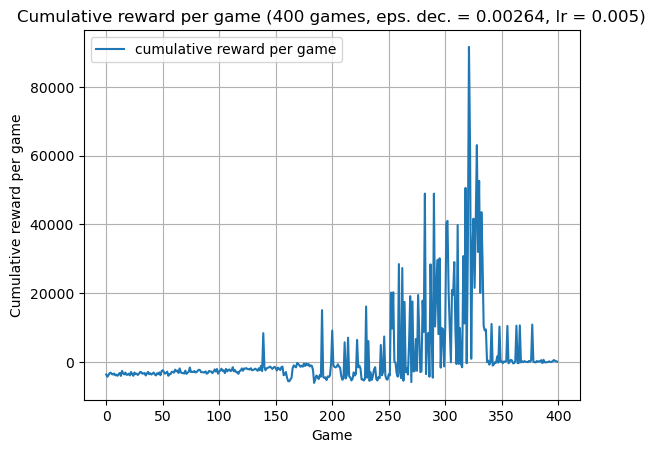

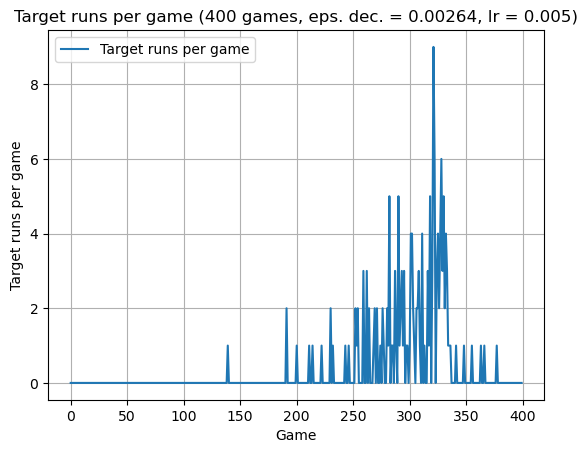

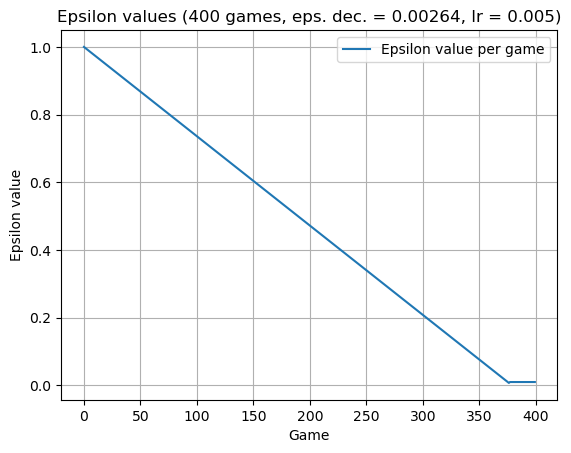

In [15]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 10                #Reward for moving forwards
reward_backwards = -10              #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -100                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_1_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_1.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In our first attempt, the cumulative reward per game increases slightly over the training duration of 400 games. In between, there are always very large outliers. These are games in which the agent has reached the goal comparatively often. If you let the trained agent play, you can see that the agent only stops and does not move forward. Incidentally, there was an error in the course of the epsilon value, because it dropped below 0.01 during one run. This error has now been corrected and will no longer occur in following attempts. Since we noticed that the agent only has to move 10 steps forward in order to compensate a car crash, we want to reduce reward_forwards in the next attempt, even though he is standing still in rendered mode after the training.

##### 6.1.3 Second attempt: reducing reward_forward from 10 to 5 #####

Episode:  0 , Cumulative reward:  -6220.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -5795.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -5950.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -6620.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -6410.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -5885.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -5725.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -6185.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -6265.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -5750.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -5905.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -6255.0 , Epsilon: 0.97096000 , Target runs:  0
Episode:  12 ,

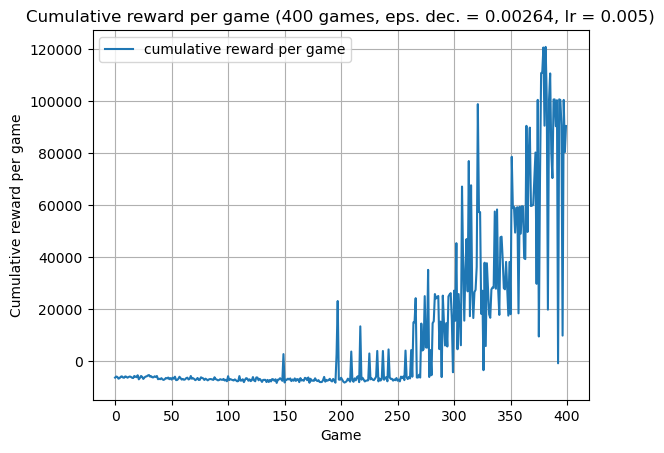

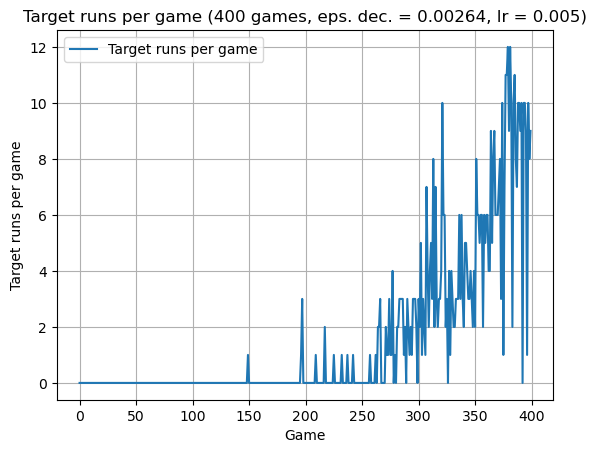

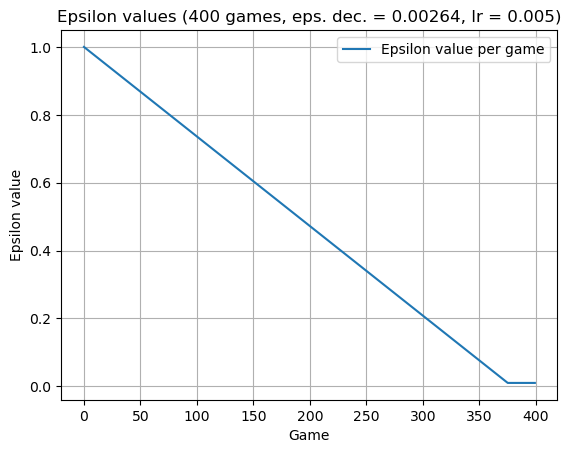

In [8]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -10              #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -100                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_2_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_2.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the second attempt, the cumulative reward per game increases significantly more over the training period compared to the first try. There is also a new record of 12 target runs within one match. However, the trained agent only runs forward, as can be seen in the rendered mode. Consequently, we assume that the reward is still too high for a target run and not negative enough for a collision. That is why we will reduce reward_crash in the following attempt. We cannot explain why the agent stopped in the first attempt and now runs permanently forwards, since lowering reward_forwards actually reduces the reward for constantly running forwards. Perhaps the multiple negative outliers of the cumulative reward caused the agent to prefer to stand still because he expects to receive less negative reward than he would recieve if he tries to cross the road.

##### 6.1.4 Third attempt: reducing reward_crash from -100 to -200 #####

Episode:  0 , Cumulative reward:  -11605.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -12615.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -11250.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -11940.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -11180.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -10895.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -12070.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -11400.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -11595.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -11585.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -12020.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -11425.0 , Epsilon: 0.97096000 , Target runs:  0
Ep

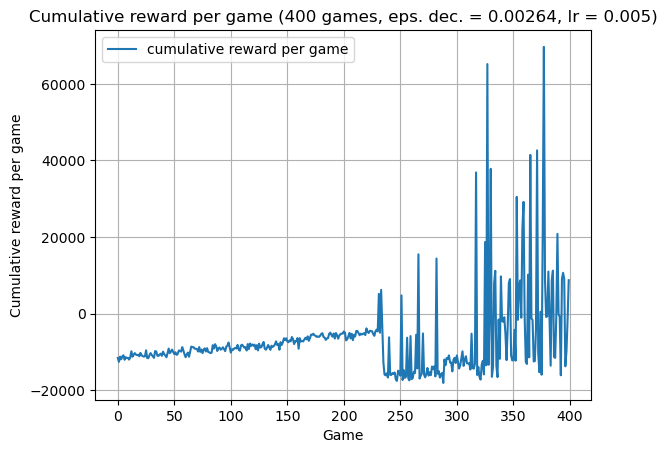

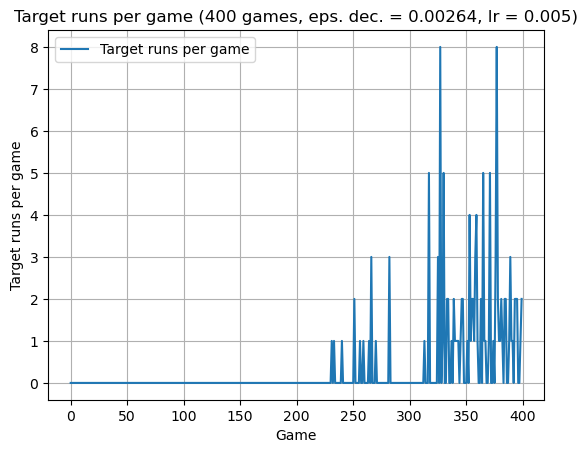

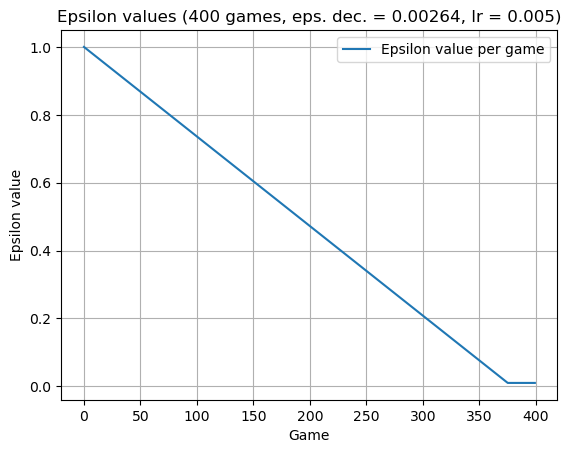

In [9]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -10              #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -200                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_3_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_3.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the third attempt, the cumulative reward increases slowly and steadily until about the 225th game, but drops significantly from there. Afterwards the reward rises again, but fluctuates strongly overall. The number of target runs per game has dropped in comparision to the previous attempt. However, the rendered mode shows that this is probably only due to the coincidence, because the agent only runs forward in this attempt as well. In order to punish dodging less we are going to increase reward_backwards in the following attempt, since the agent should try to get out of the way of the cars.

##### 6.1.5 Fourth attempt: increasing reward_backwards from -10 to -5 #####

Episode:  0 , Cumulative reward:  -8310.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -9255.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -10260.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -10295.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -10210.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -10190.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -8525.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -8525.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -10245.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -9800.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -8905.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -9525.0 , Epsilon: 0.97096000 , Target runs:  0
Episode: 

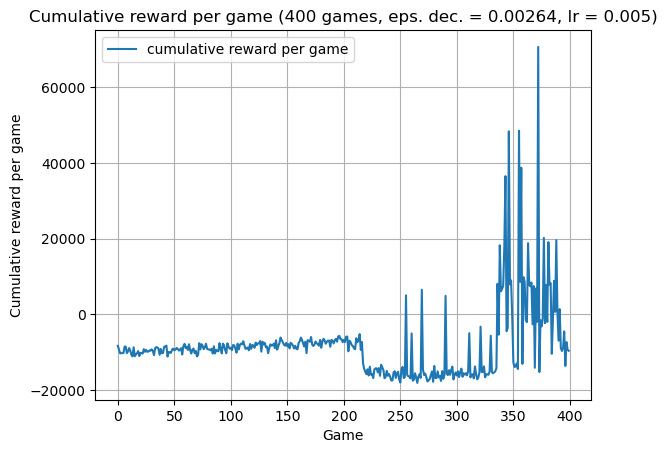

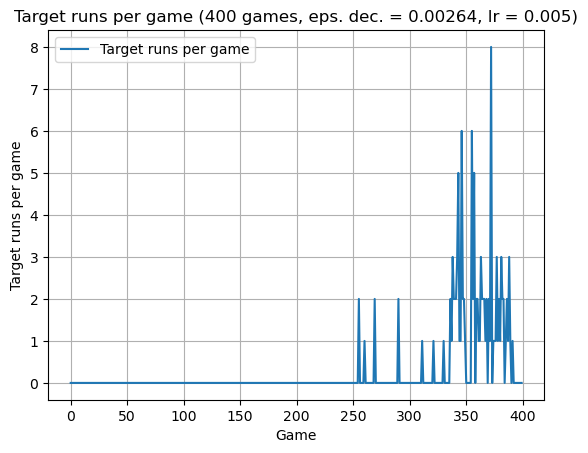

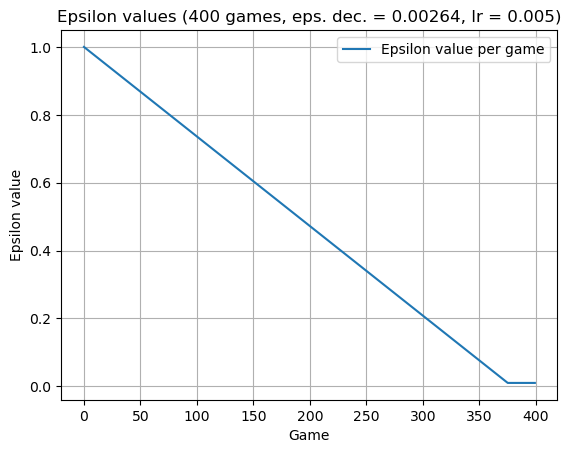

In [10]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -5               #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -200                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_4_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_4.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

As in the third attempt, there is a clear drop of the cumulative reward during training in the fourth try. The number of target runs is also similar to the third attempt. As before, the agent runs permanently straight forwards and does not try to dodge the cars. Due to this fact we are going to significantly reduce reward_goal in the following trial.

##### 6.1.6 Fifth attempt: reducing reward_goal from 10000 to 4000 #####

Episode:  0 , Cumulative reward:  -10935.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -9330.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -9960.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -10495.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -11150.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -9415.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -10010.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -10445.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -8440.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -9345.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -8625.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -11295.0 , Epsilon: 0.97096000 , Target runs:  0
Episode:

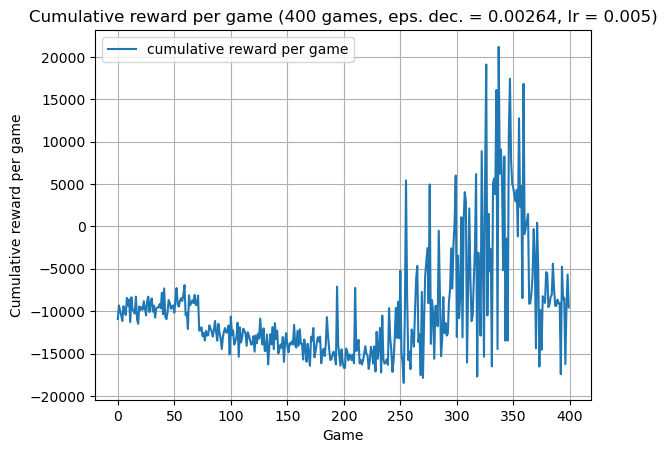

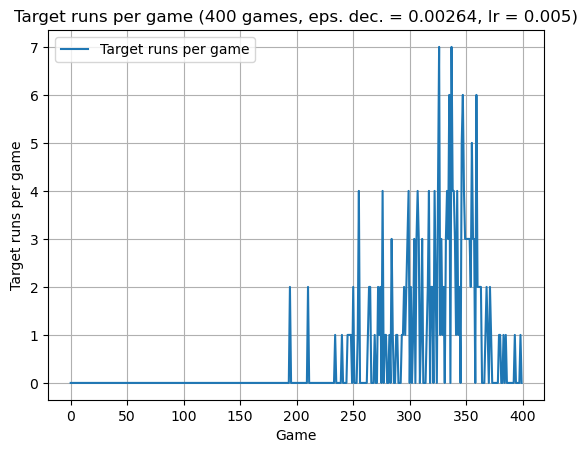

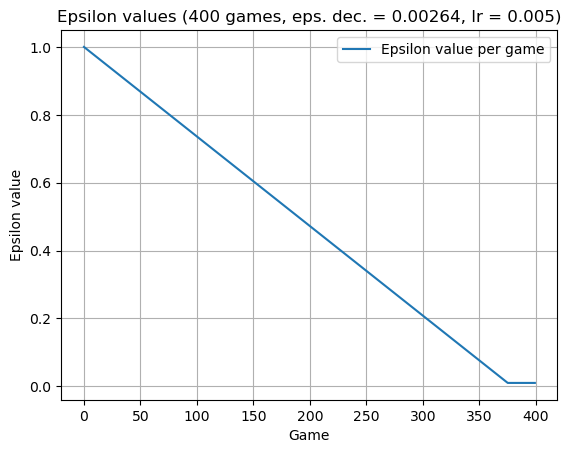

In [18]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 4000                  #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -5               #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -200                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_5_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_5.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the fifth attempt, the agent stopped again at the start in rendered mode. The cumulative reward was overall lower than in the fourth attempt, but this is probably due to the lower reward for a target run. Furthermore, the number of finishes did not change significantly. However, the reward fluctuated significantly more than in the previous attempt and, in addition, the collapse of the reward at about 225 games was eliminated. Since the agent does not run at all now, the last change of reward_goal seems to have been too big. In the following run we will raise reward_goal again.

##### 6.1.7 Sixth attempt: increasing reward_goal from 4000 to 6500 #####

Episode:  0 , Cumulative reward:  -9595.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -9270.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -11280.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -9280.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -9800.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -10900.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -9100.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -9050.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -10830.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -8375.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -10240.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -7950.0 , Epsilon: 0.97096000 , Target runs:  0
Episode:  

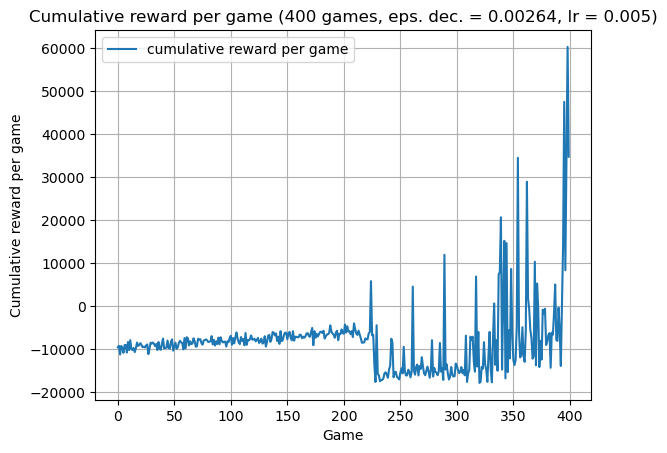

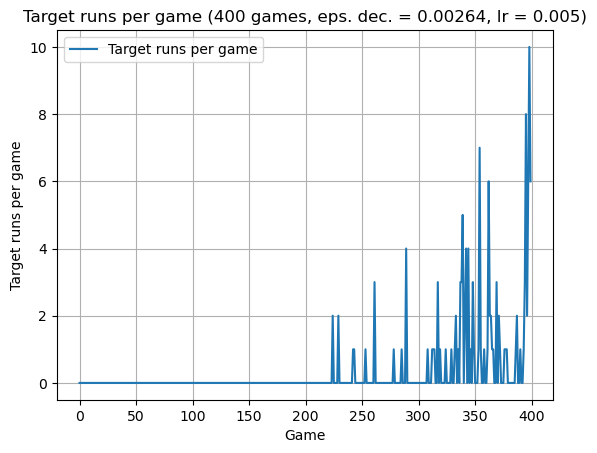

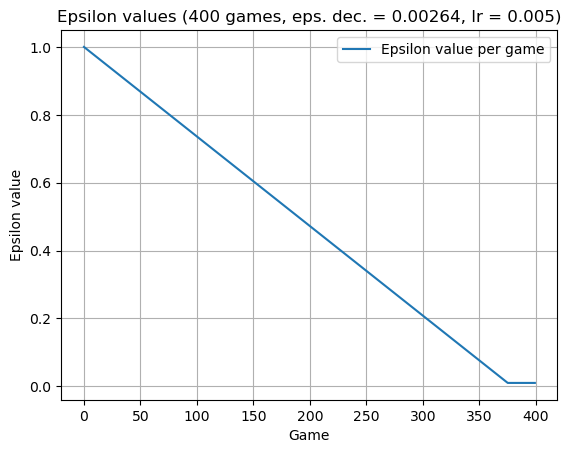

In [8]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 6500                  #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -5               #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -200                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_6_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_6.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

After the agent only stopped in the fifth attempt, we increased reward_goal again in the sixth attempt. Although the reward is now two thirds greater, the agent still stops. So the agent still does not avoid the cars. Additonally, in this attempt the cumulative reward once again collapsed after about 225 games. Out of interest, we want to increase reward_nooperation in the next attempt. So far, the agent does not receive a reward for standing still. We hope that the agent will realise that it does not necessarily has to go backwards to avoid cars, but can also remain standing. At the same time, we can also imagine that the agent now has another reason to stop at the start.

##### 6.1.8 Seventh attempt: increasing reward_nooperation from 0 to 1 #####

Episode:  0 , Cumulative reward:  -9505.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -11255.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -10490.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -9195.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -9535.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -8405.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -9820.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -10255.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -9865.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -9785.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -9590.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -9525.0 , Epsilon: 0.97096000 , Target runs:  0
Episode:  1

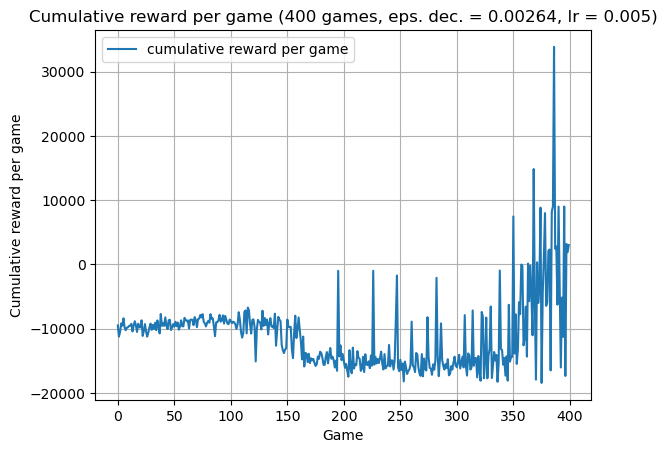

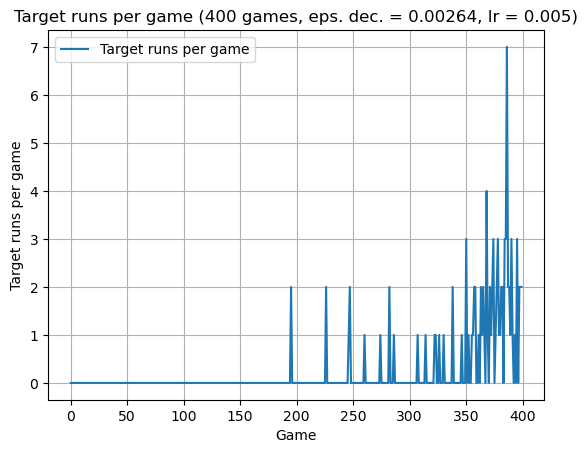

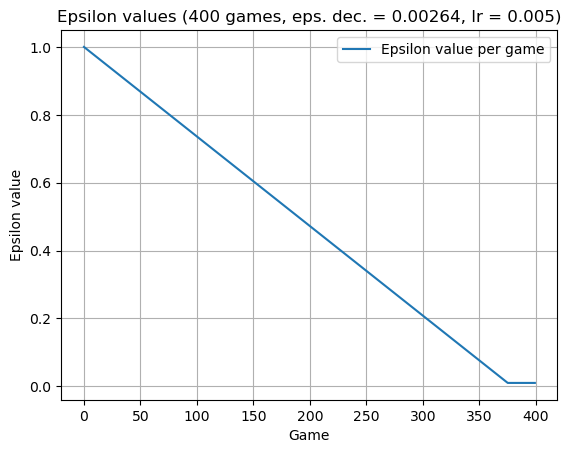

In [9]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 6500                  #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -5               #Reward for moving backwards
reward_nooperation = 1              #Reward for standing still
reward_crash = -200                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_7_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_7.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the seventh attempt, the agent ran permanently forward again. Also in this trial, the cumulative reward decreased during the training process, although less abruptly. Overall, the agent reached the goal less often during the training process than in the previous attempt. Since we have not been successfull in getting the agent to dodge cars by adjusting the rewards, we want to adjust the learning rate and the discount factor gamma in the following tries. 

##### 6.1.9 Eighth attempt: Increasing p_lr from 0.005 to 0.01 #####

Episode:  0 , Cumulative reward:  -10175.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -9340.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -10785.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -10415.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -9505.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -9830.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -9770.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -10785.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -10870.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -10415.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -11640.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -10590.0 , Epsilon: 0.97096000 , Target runs:  0
Episod

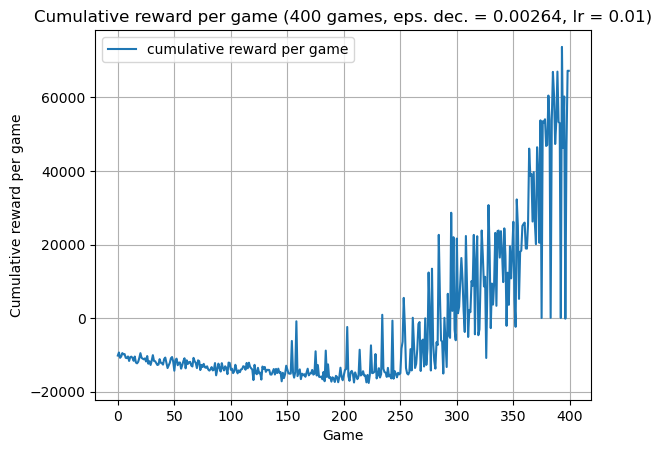

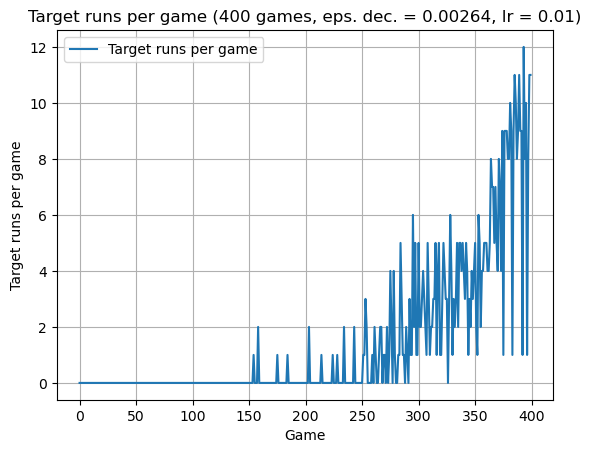

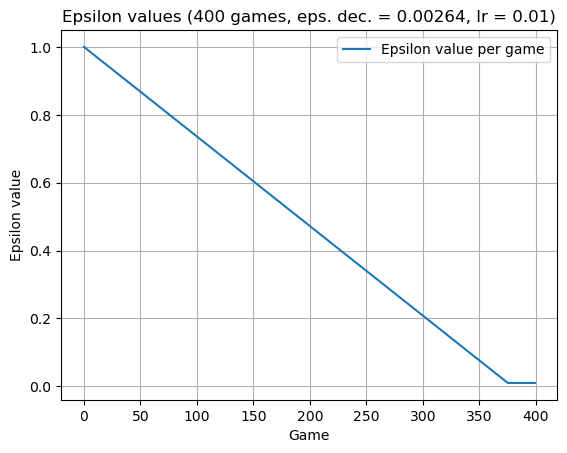

In [10]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.01                         #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 6500                  #Reward for reaching the goal
reward_forwards = 5                 #Reward for moving forwards
reward_backwards = -5               #Reward for moving backwards
reward_nooperation = 1              #Reward for standing still
reward_crash = -200                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_8_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_8.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

After we have increased the learning rate in the eighth trial, the cumulative reward increases significantly more during the training process. There is no sign of a collapse as in previous trials. In addition, the agent reaches the goal more often during training. Nevertheless, in the rendered mode you can see that the agent still runs permanently forward. In the following, we want to reduce the discount factor in order to give more weight to rewards that lie in the near future than to those that have a rewarding effect in the long term. 

##### 6.1.10 Ninth attempt: decreasing p_gamma from 0.99 to 0.5 #####

Episode:  0 , Cumulative reward:  -3750.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -3860.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -3770.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -3840.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -4610.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -4010.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -4230.0 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -4410.0 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -3610.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -4140.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -3830.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -4670.0 , Epsilon: 0.97096000 , Target runs:  0
Episode:  12 ,

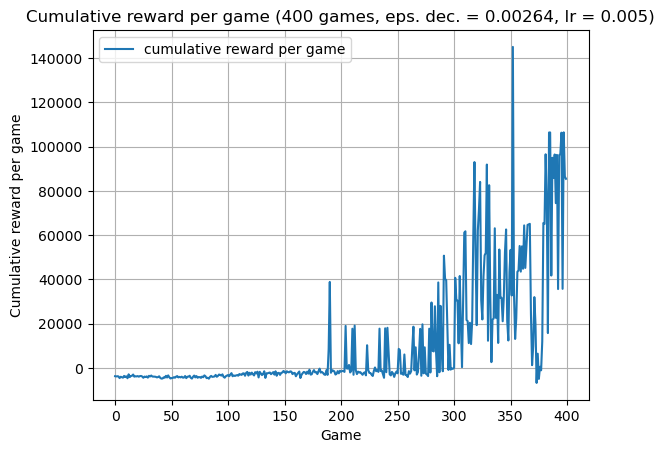

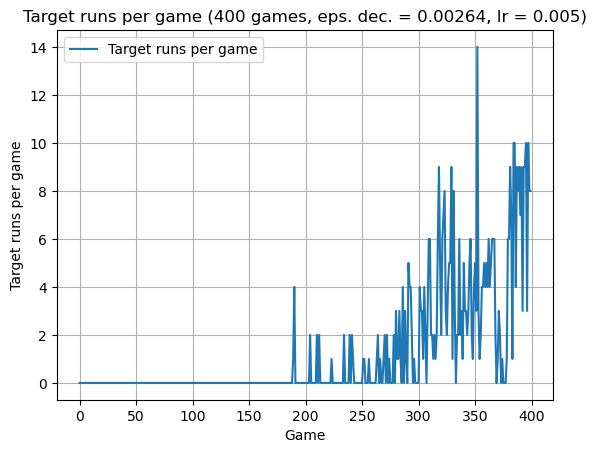

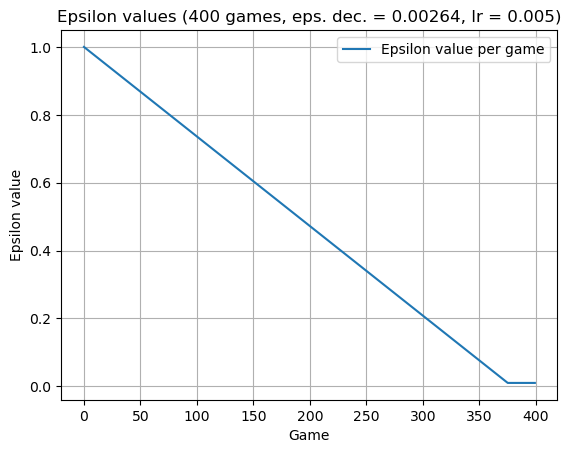

In [11]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.5                       #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 10                #Reward for moving forwards
reward_backwards = -10              #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -100                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_9_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_9.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

The graphs for the ninth trial show that the cumulative reward was constant for a much longer time during the training process, before increasing towards the end. In this trial, the agent set a new record with 14 target runs. However, the agent still runs straight forward and does not avoid the cars, even if we decrease the discount factor and weight rewards in the near future more heavily. Further on, we try out a changing discount factor during the training. For this we are adding a new function to our agent class.

##### 6.1.11 Tenth attempt: increasing the discount factor during the learning process #####

Episode:  0 , Cumulative reward:  -3240.0 , Epsilon: 1.00000000 , Gamma: 0.01000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -3810.0 , Epsilon: 0.99736000 , Gamma: 0.01245000 , Target runs:  0
Episode:  2 , Cumulative reward:  -3690.0 , Epsilon: 0.99472000 , Gamma: 0.01490000 , Target runs:  0
Episode:  3 , Cumulative reward:  -3460.0 , Epsilon: 0.99208000 , Gamma: 0.01735000 , Target runs:  0
Episode:  4 , Cumulative reward:  -3510.0 , Epsilon: 0.98944000 , Gamma: 0.01980000 , Target runs:  0
Episode:  5 , Cumulative reward:  -4440.0 , Epsilon: 0.98680000 , Gamma: 0.02225000 , Target runs:  0
Episode:  6 , Cumulative reward:  -4090.0 , Epsilon: 0.98416000 , Gamma: 0.02470000 , Target runs:  0
Episode:  7 , Cumulative reward:  -3810.0 , Epsilon: 0.98152000 , Gamma: 0.02715000 , Target runs:  0
Episode:  8 , Cumulative reward:  -4490.0 , Epsilon: 0.97888000 , Gamma: 0.02960000 , Target runs:  0
Episode:  9 , Cumulative reward:  -3130.0 , Epsilon: 0.97624000 , Gamma: 0.0320500

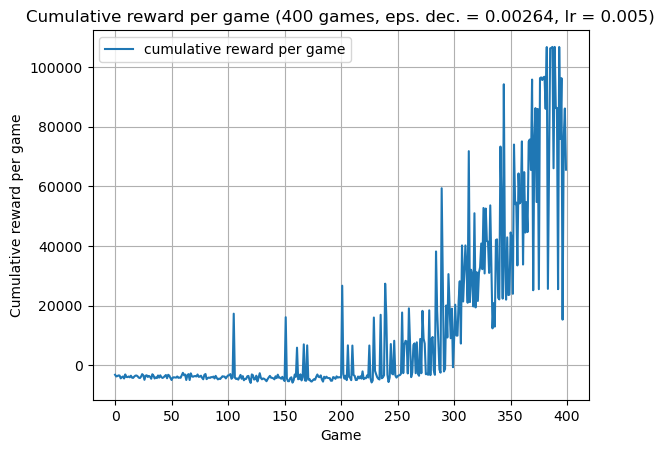

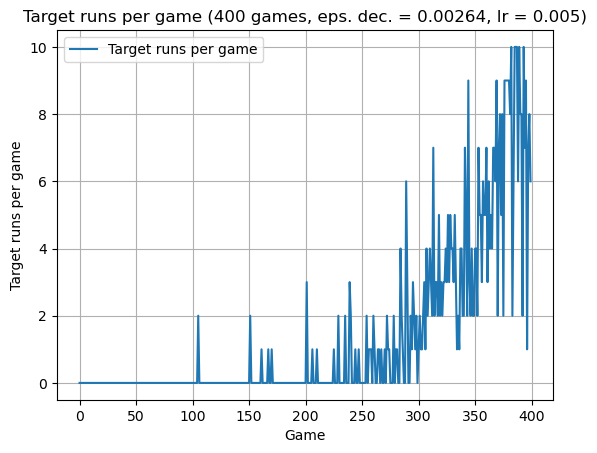

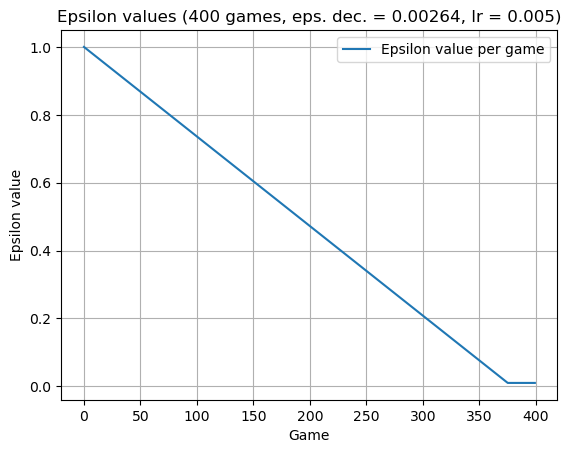

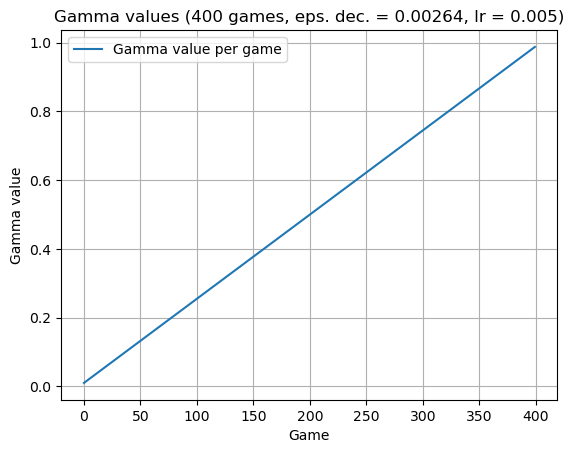

[0.01, 0.01245, 0.0149, 0.01735, 0.0198, 0.022250000000000002, 0.024700000000000003, 0.027150000000000004, 0.029600000000000005, 0.03205, 0.0345, 0.036950000000000004, 0.039400000000000004, 0.041850000000000005, 0.044300000000000006, 0.04675000000000001, 0.04920000000000001, 0.05165000000000001, 0.05410000000000001, 0.05655000000000001, 0.05900000000000001, 0.06145000000000001, 0.06390000000000001, 0.06635, 0.0688, 0.07125, 0.07369999999999999, 0.07614999999999998, 0.07859999999999998, 0.08104999999999997, 0.08349999999999996, 0.08594999999999996, 0.08839999999999995, 0.09084999999999994, 0.09329999999999994, 0.09574999999999993, 0.09819999999999993, 0.10064999999999992, 0.10309999999999991, 0.10554999999999991, 0.1079999999999999, 0.1104499999999999, 0.11289999999999989, 0.11534999999999988, 0.11779999999999988, 0.12024999999999987, 0.12269999999999986, 0.12514999999999987, 0.12759999999999988, 0.1300499999999999, 0.1324999999999999, 0.1349499999999999, 0.1373999999999999, 0.139849999

In [39]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.01                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
p_gamma_inc = 0.00245               #Discount factor increase value
reward_goal = 10000                 #Reward for reaching the goal
reward_forwards = 10                #Reward for moving forwards
reward_backwards = -10              #Reward for moving backwards
reward_nooperation = 0              #Reward for standing still
reward_crash = -100                 #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, gamma_history_list, target_runs_list = [], [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)
    gamma_history_list.append(agent.gamma)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Gamma: %.8f' % agent.gamma, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Updating gamma
    Agent.increaseGamma(agent, p_gamma_inc)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_10_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_10.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Discount factor increase value: {p_gamma_inc}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, gamma_history_list, label = "Gamma value per game")                             #Gamma history
plt.title(f"Gamma values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Gamma value")
plt.legend()
plt.grid()
plt.show()

#Printing the gamma history for testing purposes
#print(gamma_history_list)

In the tenth attempt, we steadily increased the discount factor gamma during the training. Thus, with increasing duration, the agent placed a greater focus on the rewards that lay in the distant future. The cumulative reward stagnated until the 250th game, before it increased significantly. The situation was similar with the target runs. These increased at about the same time. Unfortunately, even after trying this first reward function several times, we were not able to get the agent to try to avoid the cars. Just like in this test, the agent runs forward continuously or stops at its starting position and does not move. <br>
(Note: the list with the gamma history does not play any further role. It was displayed for testing purposes, but was mistakenly not removed before the actual training).

#### 6.2 Second reward function ####

##### 6.2.1 The reward function #####

Since we unfortunately had no success with our previous reward function and the chicken always just stops or runs forward continuously, we now want to try out a new approach for the reward function in this section. The following function has already been successfully used by our fourth group member Tobias in his approach, so we now want to test it in our deep q network as well. In contrast to the first function, forward or backwards steps as well as stopping are not rewarded anymore. Just as with the first reward function, reaching the goal is rewarded positively and a collision with a car is rewarded negatively. In addition to these two values, the agent now always receives a reward depending on its y-coordinate in the environment, no matter how he moves. The function we used for this y-coordinate dependent reward is plotted below.

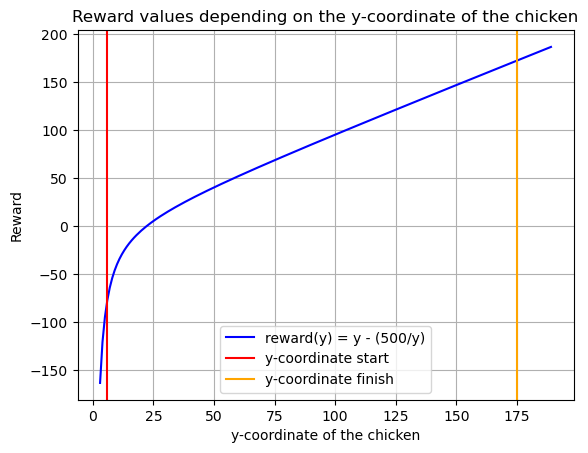

In [30]:
#Note that the chicken can only move between the y-values 6 to 175. Further values are only shown for optical reasons.
x = np.arange(3, 190, 1)

#Plotting the function
plt.plot(x, x - (500/x) , label = "reward(y) = y - (500/y)", color = "blue")
plt.axvline(6, label = "y-coordinate start", color = "red")
plt.axvline(175, label = "y-coordinate finish", color = "orange")
plt.title("Reward values depending on the y-coordinate of the chicken")
plt.xlabel("y-coordinate of the chicken")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

In [32]:
class ClipReward_2(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward
        self.target_runs = 0                                #number of target runs

    #Method to calculate the reward
    def reward(self, reward):
        #Recieving the RAM
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reset and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]

        if(current_pos >= 175): 
            #Chicken reaches the goal
            reward = reward_goal
            self.target_runs += 1
        elif(self.pre_pos > 6 and (not cooldown == 0)):
            #Chicken collides with a car (reset)
            #By checking the cooldown value we are making sure that the we detect a "false" collision
            #Otherwise the agent would get a negative reward for moving forwards and then immediately backwards)
            reward = reward_crash
        #Chicken recieves a reward connected to its current position on the road (independent from crash or goal)
        reward += current_pos - (500 / current_pos)
        
        #Getting new previous position
        self.pre_pos = current_pos
        #Returning reward
        return np.clip(reward, self.min_reward, self.max_reward)

    #Method to recieve the number target runs
    def get_TargetRuns(self):
        return self.target_runs

    #Method to reset the number of target runs
    def reset_TargetRuns(self):
        self.target_runs = 0

##### 6.2.2 Eleventh attempt: trying the second reward function #####

Episode:  0 , Cumulative reward:  -110887.78500506224 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -118797.72689759485 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -108437.64036419959 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -115659.94116608406 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -102347.57231062032 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -120161.21350634501 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -114468.80492315262 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -110380.85050924619 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -117953.72917827818 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -121691.09862687034 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -111661.79805086784 , Eps

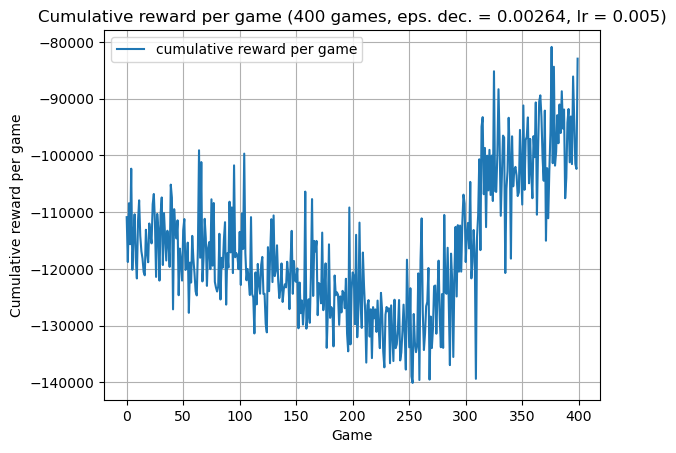

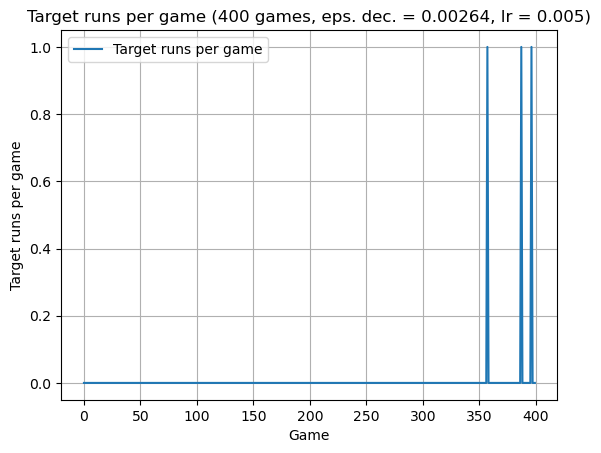

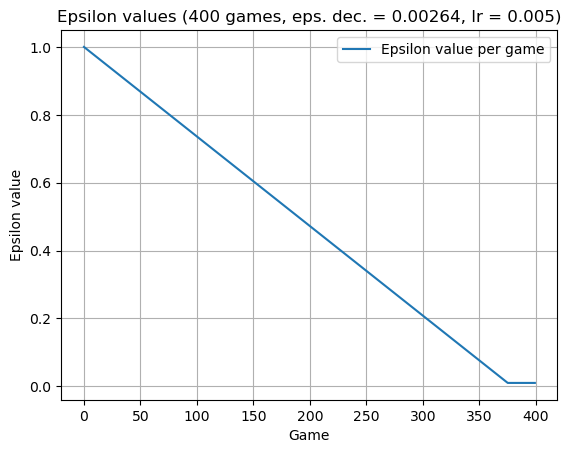

In [12]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_2.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_2.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_11_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_11.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

Even when using the new reward function, the agent continues to run straight forward in rendered mode. However, the course of the cumulative reward during the training has changed. While this tended to increase over the entire training time when using the first reward function, the cumulative reward decreases in the twelfth attempt at the beginning. Only after about 250 games the trend increases. It is also noteworthy that the agent in this experiment only reached the goal three times during the entire training period.

##### 6.2.3 Twelfth attempt: increasing dims_fc1 and dims_fc2 from 256 to 1024 each ##### 

Episode:  0 , Cumulative reward:  -122888.36570255364 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -118423.38907665534 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -109836.49385541883 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -119021.23836682887 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -116296.85584809064 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -114137.77348808601 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -117679.43326677116 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -118769.50516746726 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -120976.98645453155 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -116110.71994520121 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -114928.81503275713 , Eps

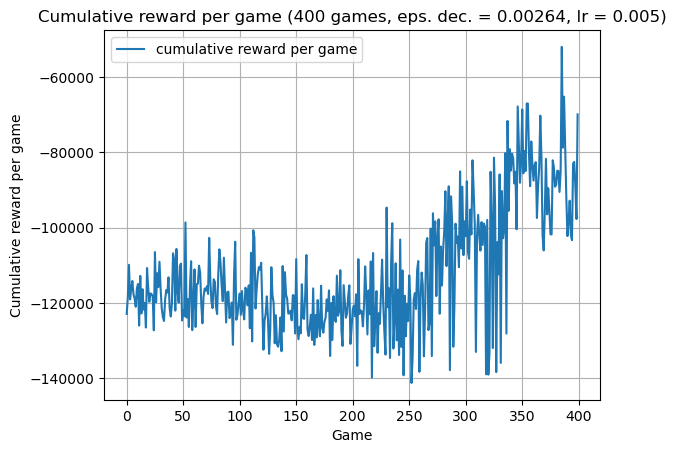

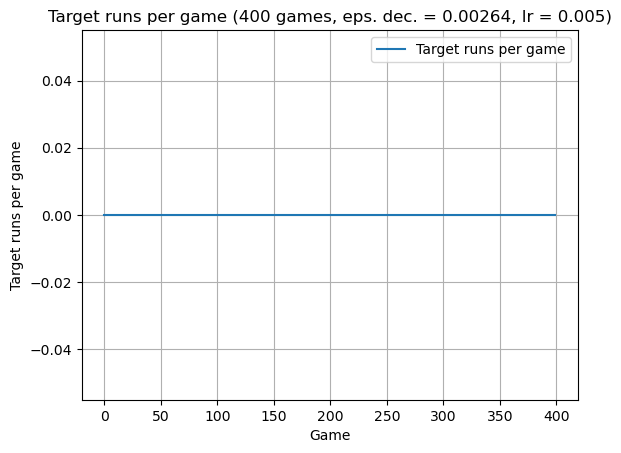

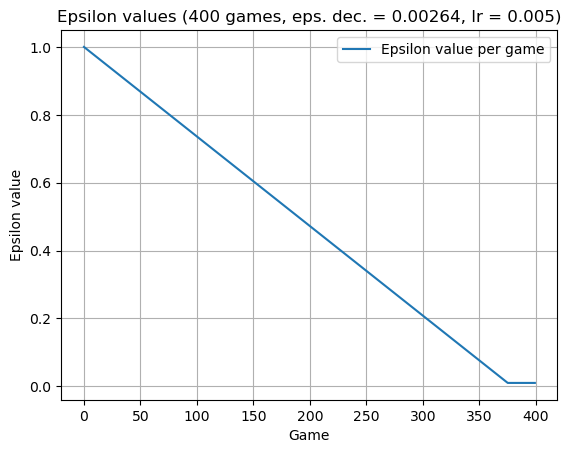

In [13]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 1024                   #Dimension of the first fully connected layer
p_dims_fc2 = 1024                   #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_2.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_2.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_12_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_12.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

After we have increased the input dimensions of the layers from 256 to 1024 each in the twelfth attempt, the agent just stops. Compared to the previous trial, the descent of the cumulative reward at the beginning of the training is much smaller. Moreover, the agent did not even make it to the goal during this training. In the following experiment, we want to reduce batch_size from 64 to 16.

##### 6.2.4 Thirteenth attempt: reducing batch_size from 64 to 16 ##### 

Episode:  0 , Cumulative reward:  -112400.27298284914 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -123234.87577866811 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -108872.16213672418 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -120058.06881164025 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -118329.41446046472 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -119366.17637241574 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -113185.87295827716 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -121013.2437083257 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -117716.23663604536 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -116681.16397820164 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -110040.82650203594 , Epsi

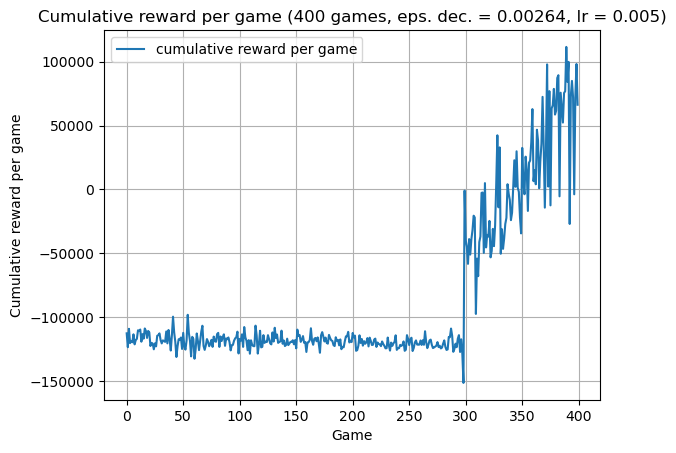

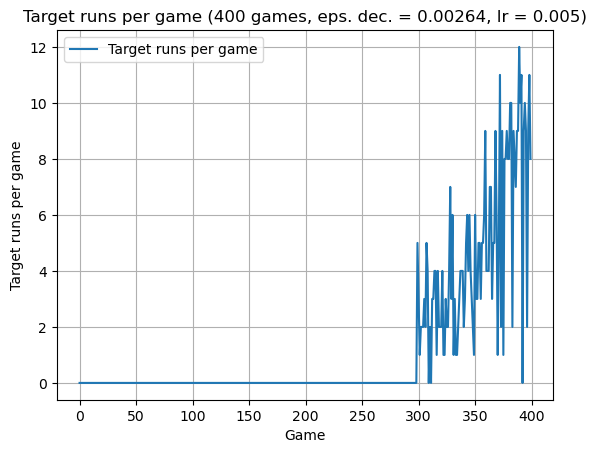

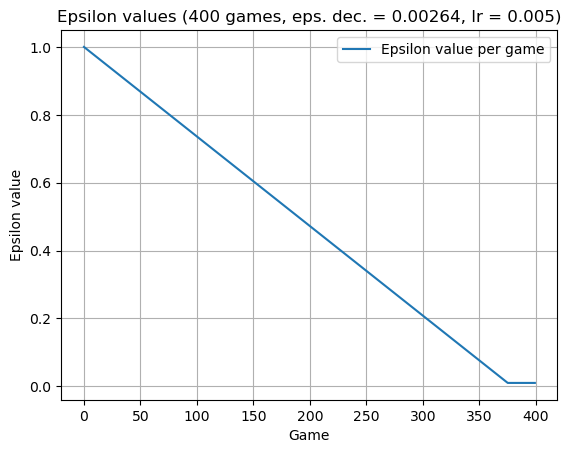

In [14]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 1024                   #Dimension of the first fully connected layer
p_dims_fc2 = 1024                   #Dimension of the second fully connected layer
p_batch_size = 16                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_2.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_2.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_13_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_13.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the thirteenth attempt, the agent once again runs straight without a break. Compared to the twelfth trial, the agent made it to the finish during the training trial. Furthermore, the cumulative reward behaved significantly differently. Up to the 300th game, the cumulative reward stagnated until it then increased significantly and was almost permanently positive from the 350th game onwards. In the fourteenth attempt we will increase max_mem_size from 1000000 to 1500000.

##### 6.2.5 Fourteenth attempt: inceasing max_mem_size from 1000000 to 1500000 ##### 

In [ ]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.005                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 1024                   #Dimension of the first fully connected layer
p_dims_fc2 = 1024                   #Dimension of the second fully connected layer
p_batch_size = 16                   #Batch size
p_max_mem_size = 1500000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_2.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_2.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_14_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_14.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

# ANALYSE EINFÜGEN #

#### 6.3 Third reward function ####

##### 6.3.1 The reward function #####

The second reward function previously used by Tobias was also unsuccessful. In a third attempt, we now want to use a reward function that is similar to the second one. As before, there is a positive reward for reaching the goal, a negative reward for a collision with a car and a permanent reward depending on the y-coordinate of the chicken. However, we now use a linear curve for this. It originates from the function used before. By using this function, the agent is longer negatively penalised for a low y-coordinate. The function we used for this y-coordinate dependent reward is plotted below.

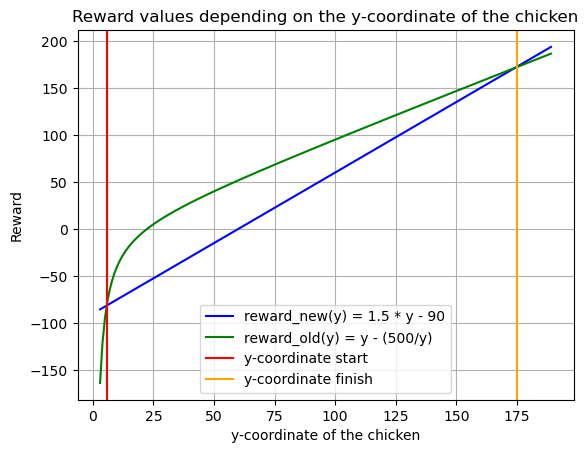

In [37]:
#Note that the chicken can only move between the y-values 6 to 175. Further values are only shown for optical reasons.
x = np.arange(3, 190, 1)

#Plotting the function
plt.plot(x, 1.5 * x - 90, label = "reward_new(y) = 1.5 * y - 90", color = "blue")
plt.plot(x, x - (500/x) , label = "reward_old(y) = y - (500/y)", color = "green")
plt.axvline(6, label = "y-coordinate start", color = "red")
plt.axvline(175, label = "y-coordinate finish", color = "orange")
plt.title("Reward values depending on the y-coordinate of the chicken")
plt.xlabel("y-coordinate of the chicken")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

In [38]:
class ClipReward_3(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward
        self.target_runs = 0                                #number of target runs

    #Method to calculate the reward
    def reward(self, reward):
        #Recieving the RAM
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reset and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]

        if(current_pos >= 175): 
            #Chicken reaches the goal
            reward = reward_goal
            self.target_runs += 1
        elif(self.pre_pos > 6 and (not cooldown == 0)):
            #Chicken collides with a car (reset)
            #By checking the cooldown value we are making sure that the we detect a "false" collision
            #Otherwise the agent would get a negative reward for moving forwards and then immediately backwards)
            reward = reward_crash
        #Chicken recieves a reward connected to its current position on the road (independent from crash or goal)
        reward += 1.5 * current_pos - 90
        
        #Getting new previous position
        self.pre_pos = current_pos
        #Returning reward
        return np.clip(reward, self.min_reward, self.max_reward)

    #Method to recieve the number target runs
    def get_TargetRuns(self):
        return self.target_runs

    #Method to reset the number of target runs
    def reset_TargetRuns(self):
        self.target_runs = 0

##### 6.3.2 Fifteenth attempt: trying the third reward function #####

Episode:  0 , Cumulative reward:  -213906.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -209507.0 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -217398.5 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -210381.0 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -206537.5 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -213652.0 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -216963.5 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -205157.5 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -206564.0 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -195994.5 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -204932.5 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -207209.5 , Epsilon: 0.97096000 , Target

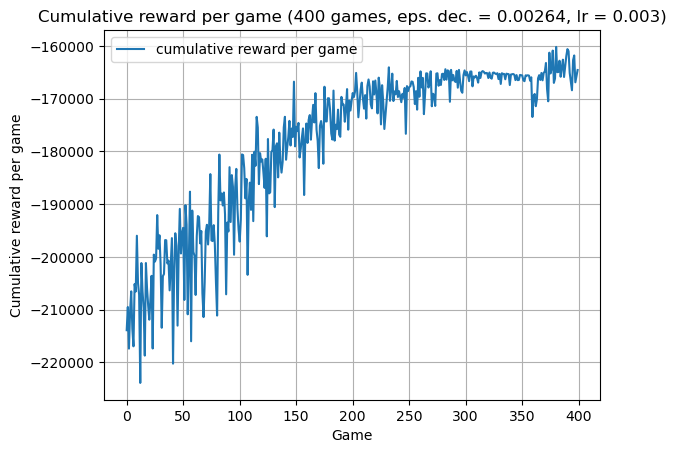

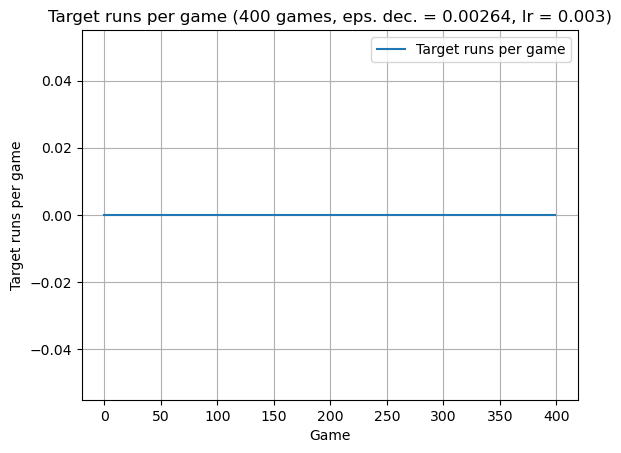

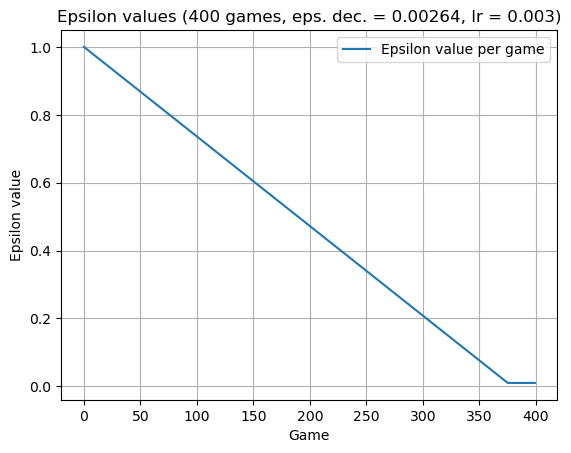

In [40]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.003                        #Learning rate
p_gamma = 0.99                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_3(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_3.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_3.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_15_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_15.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the fifteenth attempt, we tried the third reward function for the first time. In contrast to many previous trainings, the cumulative reward increased right from the start. As the training progressed, the increase continued to decrease, before stagnating from the 300th game onwards, with the exception of a few outliers. However, the agent did not even manage to reach the target during the training. Accordingly, the fact that the agent only stops at the start in rendered mode is only slightly surprising. In the next attempt, we will reduce the discount factor, similar to what we have already done with the second reward function.

##### 6.3.3 Sixteenth attempt: decreasing p_gamma from 0.99 to 0.75 #####

Episode:  0 , Cumulative reward:  -211648.0 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -203159.5 , Epsilon: 0.99736000 , Target runs:  0
Episode:  2 , Cumulative reward:  -230027.0 , Epsilon: 0.99472000 , Target runs:  0
Episode:  3 , Cumulative reward:  -205279.5 , Epsilon: 0.99208000 , Target runs:  0
Episode:  4 , Cumulative reward:  -203303.0 , Epsilon: 0.98944000 , Target runs:  0
Episode:  5 , Cumulative reward:  -205002.5 , Epsilon: 0.98680000 , Target runs:  0
Episode:  6 , Cumulative reward:  -214853.5 , Epsilon: 0.98416000 , Target runs:  0
Episode:  7 , Cumulative reward:  -203892.5 , Epsilon: 0.98152000 , Target runs:  0
Episode:  8 , Cumulative reward:  -210826.5 , Epsilon: 0.97888000 , Target runs:  0
Episode:  9 , Cumulative reward:  -201555.0 , Epsilon: 0.97624000 , Target runs:  0
Episode:  10 , Cumulative reward:  -203806.0 , Epsilon: 0.97360000 , Target runs:  0
Episode:  11 , Cumulative reward:  -207795.5 , Epsilon: 0.97096000 , Target

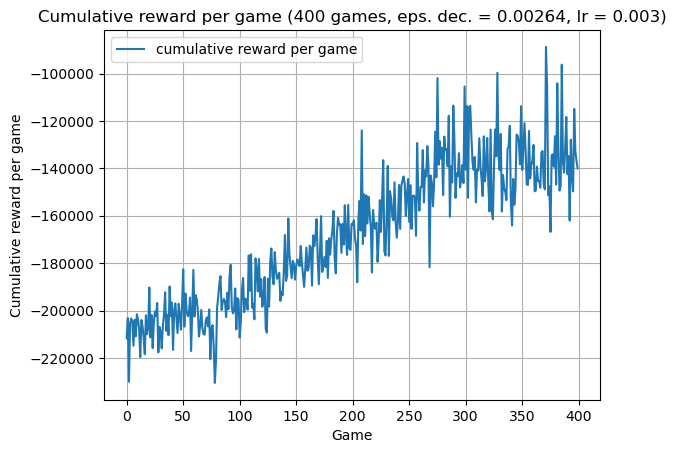

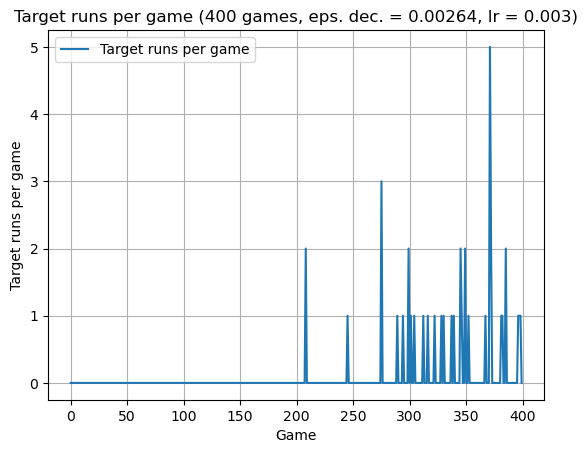

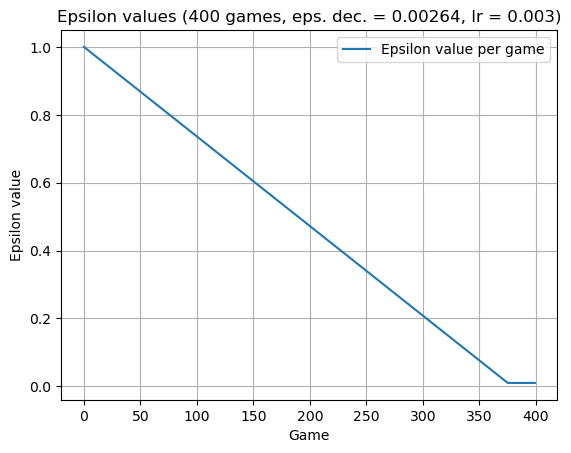

In [41]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.003                        #Learning rate
p_gamma = 0.75                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_3(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_3.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_3.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_16_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_16.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In the sixteenth experiment, we reduced the discount factor gamma to focus on rewards in the near future, as in a previous experiment with the second reward function. As in the fifteenth attempt, the cumulative reward increased right from the start, but slightly less. Compared to the previous attempt, however, the agent made it to the finish line (several times). If you test the trained model in rendered mode, you can see that the agent runs permanently to the front.

##### 6.3.4 Seventeenth attempt #####

In [ ]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.003                        #Learning rate
p_gamma = 0.75                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_3(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_3.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_3.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_17_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_17.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

# ANALYSE EINFÜGEN # 

##### 6.3.5 Eighteenth attempt #####

In [ ]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.00264                 #Epsilon descent value
p_eps_end = 0.01                    #Epsilon final value
p_lr = 0.003                        #Learning rate
p_gamma = 0.75                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 1000000            #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_3(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False
    #Recieving the first state
    observation = env.reset()[0]

    while not done:
        #Choose an action (after conversion from int to float values)
        action = agent.choose_action(np.float32(observation))

        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_3.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history, the target runs and the gamma history
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_3.reset_TargetRuns(env)

    #Updating epsilon
    Agent.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_18_episode'+ str(i) +'.pth'
        T.save(Agent.getModel(agent), saving_path)

#Saving the trained model
T.save(Agent.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_18.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

# ANALYSE EINFÜGEN # 

#### 6.4 Testing a trained model ####

Trained models can be tested in the following section. For this purpose, the parameters at the beginning of the cell must be adjusted. In particular, it is important to set the epsilon value to 0 rigth from the beginning. In addition to the parameters, the path through which the trained model is imported must be updated.

In [45]:
#The following parameters might have to be adjusted:
p_epsilon = 0.0                     #Epsilon start value
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward

#The following parameters do not have an influence on the model:
p_eps_dec = 0.002                   #Epsilon descent value (does not matter here)
p_eps_end = 0.05                    #Epsilon final value ()
p_lr = 0.003                        #Learning rate
p_gamma = 0.95                      #Discount factor
p_dims_input = 128                  #Dimension of the input
p_batch_size = 16                   #Batch size
p_max_mem_size = 100000             #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 400                     #Number of games

#Creating the environment and the agent
env = ClipReward_1(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "ram", render_mode = "human"), p_min_reward, p_max_reward)
agent = Agent(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#The following path might has to be adjusted:
Agent.setModel(agent, 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_try_16.pth')

#Recieving the first state
observation = env.reset()[0]
done = False

while not done:
    #Choose an action
    action = agent.choose_action(np.float32(observation))

    #Taking the choosen action
    done = env.step(action)[2]
    
    #Rendering the environment
    env.render()

KeyboardInterrupt: 

### 7. Using a convolutional neural network #

After working on a first neural network during the first half of the semester, we are now going to split our group into the three individuals. Here, everyone is going to work on a more specific task. Simon is investigating the effects of limiting the RAM. Paul, on the other hand, will implement a cnn that uses a cropped rgb image as input. And I will also work on a cnn, but in contrast to Paul, my neural network is going to use an unprocessed grayscale image as input. In the final presentation of the course we will then compare our three approaches with the previously implemented dqn as well as Tobias modelbased approach and draw conclusions regarding our success.

#### Function for preprocessing ####

In order to use a grayscale image as the input for a convolutional neural network, i am going to define a function for the preprocessing - but before a short recap of the observation space:
If we are setting the parameter obs_type to grayscale during the initialization of our environment we will get a 210 x 160 pixel grayscale image as an observation. The image is passed as a two-dimensional array with the dimensions 210 and 160. Each value in this array is between 0 and 255 (unsigned int using 8 bits) and represents an amount of light in this pixel.

In [157]:
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "grayscale")

print(F"Shape of the observation space: {env.observation_space}")

sample = env.observation_space.sample()
#print(sample)
print(F"Shape of a sample: {sample.shape}")

Shape of the observation space: Box(0, 255, (210, 160), uint8)
Shape of a sample: (210, 160)


c:\Users\Jan Felix\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


In order to use such an array as input for the subsequent CNN, it is first necessary to process the image. The following function 

In [159]:
#Method to preprocess an image in order to use it as an input for the cnn
def preprocessing(self, image):
        
        input = image[25: 185]
        input = input.reshape(1, 160, 160)
        input = np.expand_dims(input, axis = 0)
        input = T.tensor(input)
        
        return input

image = np.array([np.arange(160) for i in range(210)])
result = preprocessing(image)
print(result.shape)

torch.Size([1, 1, 160, 160])


In [172]:
def preprocessing(image):
    input = T.tensor(image[25: 185])
    input = T.reshape(input, (1, 160, 160))
    input = input.expand((1, 1, 160, 160))
    return input

image = np.array([np.arange(160) for i in range(210)])
result = preprocessing(image)
print(result.shape)
print(result)



    def preprocessing2(self, image):
        
        input = image[25: 185]
        input = input.reshape(1, 160, 160)
        input = np.expand_dims(input, axis = 0)
        input = T.tensor(input)
        
        return input

torch.Size([1, 1, 160, 160])
tensor([[[[  0,   1,   2,  ..., 157, 158, 159],
          [  0,   1,   2,  ..., 157, 158, 159],
          [  0,   1,   2,  ..., 157, 158, 159],
          ...,
          [  0,   1,   2,  ..., 157, 158, 159],
          [  0,   1,   2,  ..., 157, 158, 159],
          [  0,   1,   2,  ..., 157, 158, 159]]]], dtype=torch.int32)


In [7]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt


In [8]:
class CNN(nn.Module):
    #Method to initialize the cnn
    def __init__(self, lr, dims_input, dims_conv1, dims_conv2, n_actions):
        #Inheritance: calling the constructor of the super class
        super(CNN, self).__init__()
        #Saving the given parameters
        self.lr = lr                                                #Learning rate
        self.dims_input = dims_input                                #Dimensions of the input
        self.dims_conv1 = dims_conv1                                #Dimensions of the first fully connected layer
        self.dims_conv2 = dims_conv2                                #Dimensions of the second fully connected layer
        self.n_actions = n_actions                                  #Number of possible actions

        #On each layer a linear transformation is applied
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.pool1 = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(4, 8, 5)
        self.pool2 = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(8*16*16, 256)
        self.fc2 = nn.Linear(256, self.n_actions)

        #Setting up the optimization function which is using the adam algorithm
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
        
        #Setting up the Mean squared error loss function
        self.loss = nn.MSELoss()

        #Choosing a GPU if possible
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    #Method to calculate actions
    def forward(self, state):
        #Applying the activiation function (relu)
        x = self.conv1(state)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 16 * 16)
        x = F.relu(self.fc1(x))

        #Only applied to the first two layers, not the output
        actions = F.softmax(self.fc2(x))

        #Returing
        return actions

In [7]:
env = gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "grayscale")
sample = env.observation_space.sample()
#210 - 160 = 50
#Wir entfernen von beiden Seiten jeweils 25 Reihen an Pixeln, um ein quadratisches Bild zu erhalten
sample = sample[25:185]
sample = sample.reshape(1, 160, 160)
sample = np.expand_dims(sample, axis = 0)
print(sample.shape)
print()

image = np.array([np.arange(160) for i in range(210)])
state = image[1:176:2, ::2]
#print(image)
#print(state)
state = np.expand_dims(state.reshape(1, 88, 80), axis = 0)
#print(state.shape)

(1, 1, 160, 160)



c:\Users\Jan Felix\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


In [9]:
class AgentCNN():
    #Method to initialize the agent
    def __init__(self, gamma, lr, epsilon, eps_dec, eps_end, dims_input, dims_fc1, dims_fc2, batch_size, max_mem_size, n_actions):
        #Saving the given parameters
        self.gamma = gamma                                             #Discount factor
        self.lr = lr                                                   #Learning rate        
        self.epsilon = epsilon                                         #Epsilon start value
        self.eps_dec = eps_dec                                         #Epsilon descent valze
        self.eps_end = eps_end                                         #Epsilon final value
        self.dims_input = dims_input                                   #Dimension of the input
        self.dims_fc1 = dims_fc1                                       #Dimension of the first fully connected layer
        self.dims_fc2 = dims_fc2                                       #Dimension of the second fully connected layer
        self.batch_size = batch_size                                   #Batch size
        self.max_mem_size = max_mem_size                               #Maximum memory size
        self.n_actions = n_actions                                     #Number of possible actions
        self.action_space = [i for i in range(n_actions)]              #Action space
        self.mem_counter = 0                                           #Counter for the memory
        self.runs = 0                                                  #Number of runs

        #Initializing our dqn (using two fully conected layers)
        self.Q_CNN = CNN(self.lr, self.dims_input, self.dims_fc1, self.dims_fc2, self.n_actions)

        #Initializing our memory (state, new state, action, reward & termination)
        self.state_memory = T.zeros((self.max_mem_size, 1, 160, 160), dtype = T.float32)
        self.new_state_memory = T.zeros((self.max_mem_size, 1, 160, 160), dtype = T.float32)
        self.action_memory = T.zeros(self.max_mem_size, dtype = T.int32)
        self.reward_memory = T.zeros(self.max_mem_size, dtype = T.float32)
        self.terminal_memory = T.zeros(self.max_mem_size, dtype = T.bool)
    
    #Method to store a transition inside the memory
    def store_transition(self, state, action, reward, state_, done):
        #Determining the storage index
        index = self.mem_counter % self.max_mem_size

        #Storing the given state, new state, reward, action and termination information
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        #Increasing the memory counter by one
        self.mem_counter += 1
    
    #Method to choose one of the previously calculated actions 
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            #Exploitation            
            actions = self.Q_CNN.forward(observation)
            #Choosing the best action (argmax returns the index of the highest value)
            action = T.argmax(actions).item()
        else:
            #Exploration (choosing a random action)
            action = np.random.choice(self.action_space)

        #Returning the selected actions
        return action

    #Method to preprocess an input image
    def preprocessing(self, image):
        #Resizing the image to a square (and converting the values from int to float32)
        input = T.tensor(image[25: 185], dtype=T.float32).to(self.Q_CNN.device)
        #Adjusting the shape to put the picture into the convolutional layers
        input = T.reshape(input, (1, 160, 160)).to(self.Q_CNN.device)

        #Returning the preprocessed image
        return input

    #Method to let the agent learn
    def learn(self):
        if self.mem_counter < self.batch_size:
            #Since the batch is empty at the beginning, we are filling it before the agent starts to learn 
            return
        
        #Setting the gradients of the optimized tensors to zero (Otherwise these are cumulated by pytorch)
        self.Q_CNN.optimizer.zero_grad()

        #Getting the highest memory index we can reach
        max_mem = min(self.mem_counter, self.max_mem_size)

        #Choosing a random memory entry (as many times as a batch is big)
        batch = np.random.choice(max_mem, size = self.batch_size, replace = False)

        """#Creating an array with the batch_size in order to slice the calculated values for the actions
        batch_index = np.arange(self.batch_size, dtype = np.int32)"""

        #Getting the states, new states, rewards, actions and termination information for the batch
        state_batch = self.state_memory[batch].detach().clone().to(self.Q_CNN.device)
        new_state_batch = self.new_state_memory[batch].detach().clone().to(self.Q_CNN.device)
        reward_batch = self.reward_memory[batch].detach().clone().to(self.Q_CNN.device)
        action_batch = self.action_memory[batch].detach().clone().to(self.Q_CNN.device)
        terminal_batch = self.terminal_memory[batch].detach().clone().to(self.Q_CNN.device)

        """#Calculating the estimate during the previous state
        #Additional slicing in order to get the estimate for the action the agent selected
        q_eval = self.Q_CNN.forward(state_batch)[batch_index, action_batch]              #The estimates for the actions the agent took
        #Calculating the estimate for the next state
        q_next = self.Q_CNN.forward(new_state_batch)
        #Setting values of terminal states to zero (there are no next states after the game finished)
        q_next[terminal_batch] = 0.0
        #Calculating the target values
        q_target = reward_batch + self.gamma * T.max(q_next, dim = 1)[0]"""

        q_eval = T.zeros(self.batch_size).to(self.Q_CNN.device)
        q_next = T.zeros((self.batch_size, self.n_actions)).to(self.Q_CNN.device)
        for i in range(self.batch_size):
            q_eval[i] = self.Q_CNN.forward(state_batch[i])[0, action_batch[i]]
            q_next[i] = self.Q_CNN.forward(new_state_batch[i]).to(self.Q_CNN.device)

        q_next[terminal_batch[0]] = 0.0

        q_target = reward_batch + self.gamma * T.max(q_next, dim = 1)[0]

        #Calculating the loss (mean squared error)
        #loss = T.tensor(nn.MSELoss(q_target, q_eval)).to(self.Q_CNN.device)
        loss = self.Q_CNN.loss(q_target, q_eval)
        
        #Perfoming backpropagation
        loss.backward()
        #Updating (optimizing) the parameters 
        self.Q_CNN.optimizer.step()

        #Increasing the number of runs
        self.runs += 1

    #Method to recieve a model
    def getModel(self):
        return self.Q_CNN

    #Method to set a trained model
    def setModel(self, path):
        self.Q_CNN = T.load(path)

    #Method to decrease the epsilon value
    def decreaseEpsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_end else self.eps_end

C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_11668\185085360.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  actions = F.softmax(self.fc2(x))


Episode:  0 , Cumulative reward:  -160374.60195358284 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -173478.22423148228 , Epsilon: 0.98100000 , Target runs:  0
Episode:  2 , Cumulative reward:  -192790.60207765407 , Epsilon: 0.96200000 , Target runs:  0
Episode:  3 , Cumulative reward:  -160666.79820741198 , Epsilon: 0.94300000 , Target runs:  0
Episode:  4 , Cumulative reward:  -170337.62764879345 , Epsilon: 0.92400000 , Target runs:  0
Episode:  5 , Cumulative reward:  -168898.9914057523 , Epsilon: 0.90500000 , Target runs:  0
Episode:  6 , Cumulative reward:  -160188.28136793707 , Epsilon: 0.88600000 , Target runs:  0
Episode:  7 , Cumulative reward:  -192699.6145411803 , Epsilon: 0.86700000 , Target runs:  0
Episode:  8 , Cumulative reward:  -204332.5388552489 , Epsilon: 0.84800000 , Target runs:  0
Episode:  9 , Cumulative reward:  -170800.89033495667 , Epsilon: 0.82900000 , Target runs:  0
Episode:  10 , Cumulative reward:  -168135.65861014088 , Epsilo

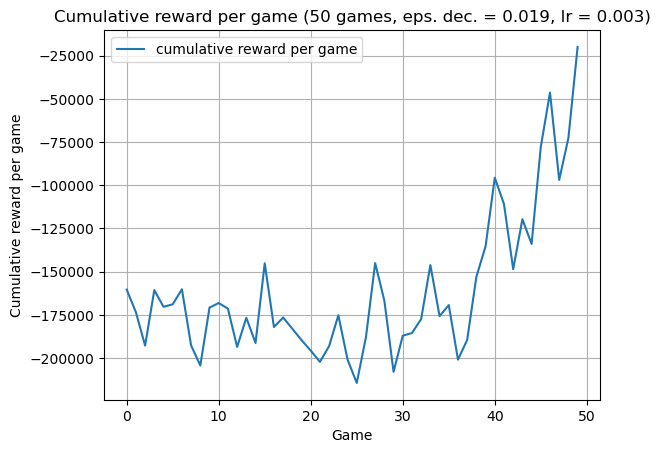

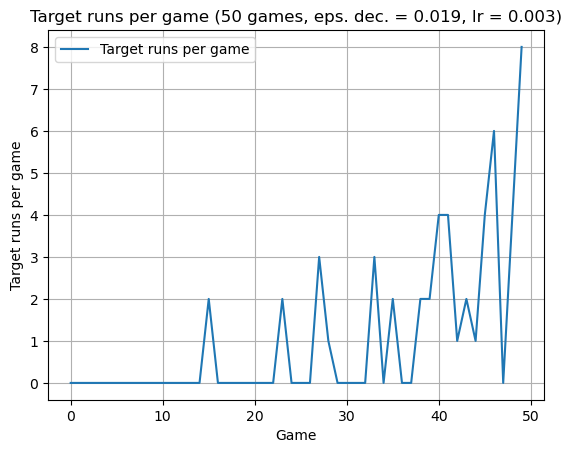

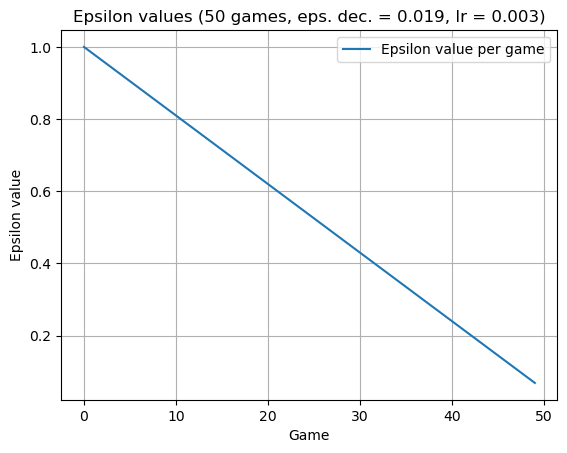

In [14]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.019                   #Epsilon descent value
p_eps_end = 0.05                    #Epsilon final value
p_lr = 0.003                        #Learning rate
p_gamma = 0.95                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 512                    #Dimension of the first fully connected layer
p_dims_fc2 = 512                    #Dimension of the second fully connected layer
p_batch_size = 32                   #Batch size
p_max_mem_size = 10000              #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 50                      #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "grayscale"), p_min_reward, p_max_reward)
agent = AgentCNN(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False

    #Recieving the first state
    observation = env.reset()[0]
    observation = AgentCNN.preprocessing(agent, observation)

    while not done:
        #Choose an action
        action = agent.choose_action(observation)
               
        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Preprocessing the new state
        observation_ = AgentCNN.preprocessing(agent, observation_)

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_1.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_1.reset_TargetRuns(env)

    #Updating epsilon
    AgentCNN.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\wewlest_episode'+ str(i) +'.pth'
        T.save(AgentCNN.getModel(agent), saving_path)
 
#Saving the trained model
T.save(AgentCNN.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\wewlest.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#The following parameters might have to be adjusted:
p_epsilon = 0.0                     #Epsilon start value
p_dims_fc1 = 256                    #Dimension of the first fully connected layer
p_dims_fc2 = 256                    #Dimension of the second fully connected layer
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#The following parameters do not have an influence on the model:
p_eps_dec = 0.002                   #Epsilon descent value (does not matter here)
p_eps_end = 0.05                    #Epsilon final value ()
p_lr = 0.003                        #Learning rate
p_gamma = 0.95                      #Discount factor
p_dims_input = 128                  #Dimension of the input
p_batch_size = 16                   #Batch size
p_max_mem_size = 100000             #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 500                     #Number of games

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "grayscale", render_mode = "human"), p_min_reward, p_max_reward)
agent = AgentCNN(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#The following path might has to be adjusted:
AgentCNN.setModel(agent, 'C:\\Users\Jan Felix\Desktop\dqn_model\wewlest.pth')

#Recieving the first state
observation = env.reset()[0]
observation = AgentCNN.preprocessing(agent, observation)
done = False

while not done:
        #Choose an action
        action = agent.choose_action(observation)
               
        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Preprocessing the new state
        observation_ = AgentCNN.preprocessing(agent, observation_)

        #Updating the previous state
        observation = observation_
        
        #Rendering the environment
        env.render()

2. Try

c:\Users\Jan Felix\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(
C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_11380\185085360.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  actions = F.softmax(self.fc2(x))


Episode:  0 , Cumulative reward:  -170860.47953912072 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -160870.36548613032 , Epsilon: 0.99050000 , Target runs:  0
Episode:  2 , Cumulative reward:  -185551.9300897154 , Epsilon: 0.98100000 , Target runs:  0
Episode:  3 , Cumulative reward:  -166681.65691140946 , Epsilon: 0.97150000 , Target runs:  0
Episode:  4 , Cumulative reward:  -173175.37861796882 , Epsilon: 0.96200000 , Target runs:  0
Episode:  5 , Cumulative reward:  -164458.12225991083 , Epsilon: 0.95250000 , Target runs:  0
Episode:  6 , Cumulative reward:  -167423.95447612766 , Epsilon: 0.94300000 , Target runs:  0
Episode:  7 , Cumulative reward:  -165837.1095083395 , Epsilon: 0.93350000 , Target runs:  0
Episode:  8 , Cumulative reward:  -177396.02627869503 , Epsilon: 0.92400000 , Target runs:  0
Episode:  9 , Cumulative reward:  -152842.09496900596 , Epsilon: 0.91450000 , Target runs:  0
Episode:  10 , Cumulative reward:  -156151.3832217744 , Epsilo

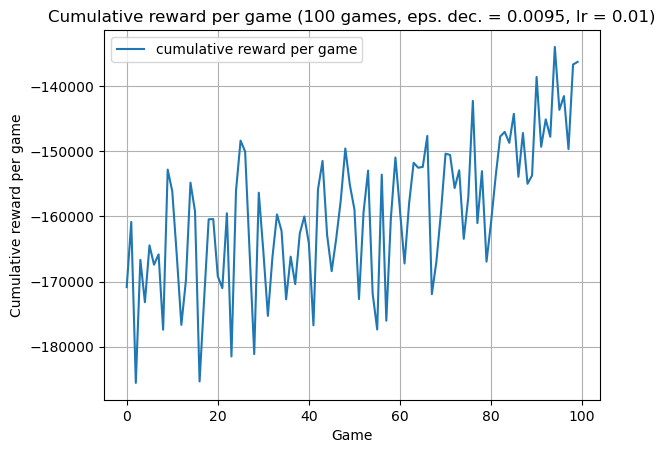

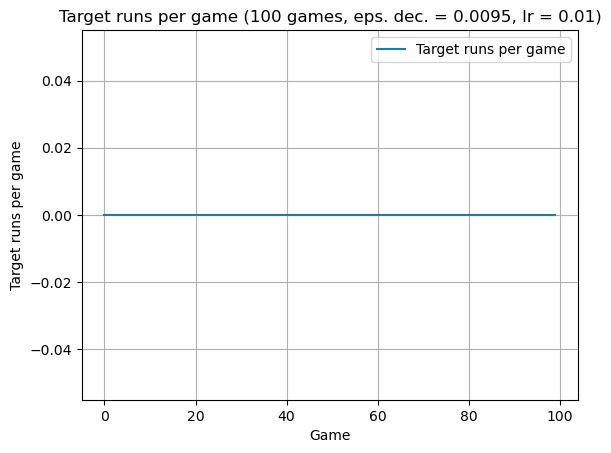

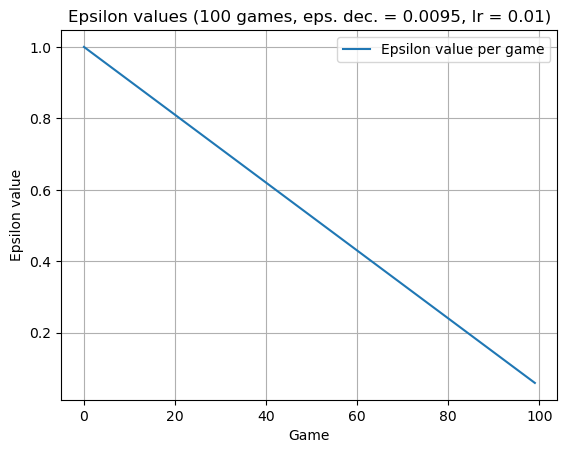

In [10]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.0095                  #Epsilon descent value
p_eps_end = 0.05                    #Epsilon final value
p_lr = 0.01                         #Learning rate
p_gamma = 0.95                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 1024                   #Dimension of the first fully connected layer
p_dims_fc2 = 1024                   #Dimension of the second fully connected layer
p_batch_size = 32                   #Batch size
p_max_mem_size = 10000              #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 100                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "grayscale"), p_min_reward, p_max_reward)
agent = AgentCNN(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False

    #Recieving the first state
    observation = env.reset()[0]
    observation = AgentCNN.preprocessing(agent, observation)

    while not done:
        #Choose an action
        action = agent.choose_action(observation)
               
        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Preprocessing the new state
        observation_ = AgentCNN.preprocessing(agent, observation_)

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_2.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_2.reset_TargetRuns(env)

    #Updating epsilon
    AgentCNN.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_model_try_2_cnn_episode'+ str(i) +'.pth'
        T.save(AgentCNN.getModel(agent), saving_path)
 
#Saving the trained model
T.save(AgentCNN.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_model_try_2_cnn.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

3. Try

In [11]:
#Setting all relevant parameters for the dqn:
p_epsilon = 1.0                     #Epsilon start value
p_eps_dec = 0.0095                  #Epsilon descent value
p_eps_end = 0.05                    #Epsilon final value
p_lr = 0.01                        #Learning rate
p_gamma = 0.95                      #Discount factor 
p_dims_input = 128                  #Dimension of the input
p_dims_fc1 = 1024                   #Dimension of the first fully connected layer
p_dims_fc2 = 1024                   #Dimension of the second fully connected layer
p_batch_size = 64                   #Batch size
p_max_mem_size = 10000              #Maximum memory size
p_n_actions = 3                     #Number of possible actions
p_n_games = 100                     #Number of games
p_max_reward = 10000000             #Maximum reward
p_min_reward = -10000000            #Minimum reward
reward_goal = 10000                 #Reward for reaching the goal
reward_crash = -1000                #Reward for colliding with a car

#Creating the environment and the agent
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "grayscale"), p_min_reward, p_max_reward)
agent = AgentCNN(p_gamma, p_lr, p_epsilon, p_eps_dec, p_eps_end, p_dims_input, p_dims_fc1, p_dims_fc2, p_batch_size, p_max_mem_size, p_n_actions)

#Creating lists for the cumulative reward, the epsilon history and the target runs
cum_reward_list, eps_history_list, target_runs_list = [], [], []

for i in range(p_n_games):
    cum_reward = 0
    done = False

    #Recieving the first state
    observation = env.reset()[0]
    observation = AgentCNN.preprocessing(agent, observation)

    while not done:
        #Choose an action
        action = agent.choose_action(observation)
               
        #Recieving the new state, reward and termination information (cutting off unnecessary information)
        observation_, reward, done = env.step(action)[:3]

        #Preprocessing the new state
        observation_ = AgentCNN.preprocessing(agent, observation_)

        #Updating the cumulative reward
        cum_reward += reward

        #Storing the transition
        agent.store_transition(observation, action, reward, observation_, done)

        #Getting the agent to learn
        agent.learn()

        #Updating the previous state
        observation = observation_

    #Recieving the number of target runs during the last game
    target_runs = ClipReward_2.get_TargetRuns(env)

    #Appending the cumulative reward, the epsilon history and the target runs
    cum_reward_list.append(cum_reward)
    eps_history_list.append(agent.epsilon)
    target_runs_list.append(target_runs)

    #Printing the most important information
    print('Episode: ', i, ', Cumulative reward: ', cum_reward, ', Epsilon: %.8f' % agent.epsilon, ', Target runs: ', target_runs)

    #Resetting the number of target runs
    ClipReward_2.reset_TargetRuns(env)

    #Updating epsilon
    AgentCNN.decreaseEpsilon(agent)

    #Saving models every 100 games (in case learning needs to be interrupted)
    if(i % 100 == 0):
        saving_path = 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_model_try_3_cnn_episode'+ str(i) +'.pth'
        T.save(AgentCNN.getModel(agent), saving_path)
 
#Saving the trained model
T.save(AgentCNN.getModel(agent), 'C:\\Users\Jan Felix\Desktop\dqn_model\dqn_model_try_3_cnn.pth')

#Results and plotting:
print('----------------------------------------------------------------------------')
print(f"""In this run we used the follwing parameters:
    Epsilon start value: {p_epsilon}
    Epsilon descent value: {p_eps_dec}
    Epsilon final value: {p_eps_end}
    Learning rate: {p_lr}
    Discount factor: {p_gamma}
    Dimension of the input: {p_dims_input}
    Dimension of the first fully connected layer: {p_dims_fc1}
    Dimension of the second fully connected layer: {p_dims_fc2}
    Batch size: {p_batch_size}
    Maximum memory size: {p_max_mem_size}
    Number of possible actions: {p_n_actions}
    Number of games: {p_n_games}
    Maximum reward: {p_max_reward}
    Minimum reward: {p_min_reward}"""
)

x = np.arange(0, p_n_games)
plt.plot(x, cum_reward_list, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_runs_list, label = "Target runs per game")                               #Amount of target runs
plt.title(f"Target runs per game ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Target runs per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_history_list, label = "Epsilon value per game")                             #Epsilon history
plt.title(f"Epsilon values ({p_n_games} games, eps. dec. = {p_eps_dec}, lr = {p_lr})")
plt.xlabel("Game")
plt.ylabel("Epsilon value")
plt.legend()
plt.grid()
plt.show()

C:\Users\Jan Felix\AppData\Local\Temp\ipykernel_11380\185085360.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  actions = F.softmax(self.fc2(x))


Episode:  0 , Cumulative reward:  -169575.92949565337 , Epsilon: 1.00000000 , Target runs:  0
Episode:  1 , Cumulative reward:  -176631.55424076095 , Epsilon: 0.99050000 , Target runs:  0
Episode:  2 , Cumulative reward:  -190060.4831675865 , Epsilon: 0.98100000 , Target runs:  0
Episode:  3 , Cumulative reward:  -162575.74408483232 , Epsilon: 0.97150000 , Target runs:  0


KeyboardInterrupt: 

### 8. Conclusion and outlook ###